## Combined body in waves — tester for tykkelse lik 0.01 MED LID

Capytaine version: 2.3.1
Torus: verts = 3840 , faces = 3840
Pipe : verts = 10560 , faces = 10560
Etter immersed_part: nb_faces = 12640
DOFs på kombinert kropp: ['Surge', 'Sway', 'Heave']


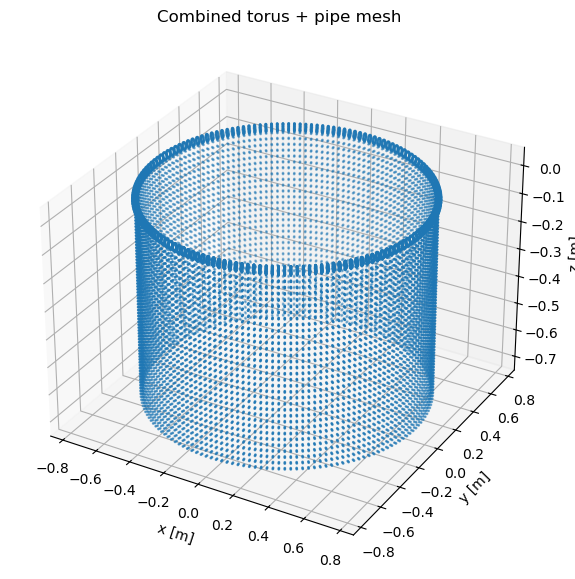

✅ STL eksportert som: not_relevant.stl
c:\Users\ingfl\anaconda3\envs\waves\python.exe


In [6]:


# COMBINED BODY: TORUS FLYTER + VERTICAL PIPE

import numpy as np
import capytaine as cpt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print("Capytaine version:", cpt.__version__)

rho = 1000.0
g   = 9.81


# ---- GEOMETRI-DEFINISJONER ----


# --- Torus / Flyter ---
R_ring  = 0.75      # [m] radius til senterlinje
r_pipe  = 0.0125     # [m] rørradius
n_maj   = 160       # oppløsning rundt ringen
n_min   = 24        # oppløsning i tverrsnittet
zc_torus = 0     # senter-høyde for torusen (øverste del i luft)

# --- Pipe / Vertikal membranrør ---
R_outer   = 0.75     # [m] røradius
thickness = 0.01     # [m] rørtykkelse
R_inner   = R_outer - thickness
H_pipe    = 0.7      # [m] neddykket høyde
z_min     = -H_pipe  # [m]
#eps       = -0.002
z_max     =  -r_pipe -0.005   #lite gap for å unngå numerisk støy

ntheta_pipe = 160
nz_pipe     = 32



# ---- FUNKSJON: Ringflate (annulus) med quads ----

def build_annulus_quads(R_outer, R_inner, z, ntheta, name="annulus", normal_up=True):
    
    #Lager en ringflate mellom R_inner og R_outer i planet z = konstant.
    #Bruker quads; normal peker oppover (+z) hvis normal_up=True, ellers nedover.
    
    theta = np.linspace(0.0, 2.0*np.pi, ntheta, endpoint=False)
    r_vals = [R_inner, R_outer]   # to sirkler: inner, outer

    verts = np.array([
        [r*np.cos(t), r*np.sin(t), z]
        for r in r_vals for t in theta
    ], dtype=float)

    def vidx(i_theta, i_rad):
        return i_rad*ntheta + (i_theta % ntheta)

    faces = []
    for i in range(ntheta):
        v00 = vidx(i,   0)   # inner ring
        v01 = vidx(i+1, 0)
        v11 = vidx(i+1, 1)   # outer ring
        v10 = vidx(i,   1)
        quad = [v00, v01, v11, v10]   # CCW sett ovenfra (+z)
        faces.append(quad if normal_up else quad[::-1])

    faces = np.asarray(faces, dtype=int)
    return cpt.Mesh(vertices=verts, faces=faces, name=name)



# ---- FUNKSJON: Bygg tykt, sirkulært pipe-mesh ----

def build_pipe_mesh(R_outer, thickness, z_min, z_max, ntheta, nz, name="pipe"):

    R_inner = R_outer - thickness

    # --- Ytre sylinder ---
    theta = np.linspace(0, 2*np.pi, ntheta, endpoint=False)
    zvals = np.linspace(z_min, z_max, nz+1)

    verts_outer = np.array([
        [R_outer*np.cos(t), R_outer*np.sin(t), z]
        for z in zvals for t in theta
    ])

    def vidx_o(i,j): return j*ntheta + (i % ntheta)

    faces_outer = []
    for j in range(nz):
        for i in range(ntheta):
            faces_outer.append([vidx_o(i,j), vidx_o(i+1,j), vidx_o(i+1,j+1), vidx_o(i,j+1)])
    faces_outer = np.asarray(faces_outer, int)
    mesh_outer  = cpt.Mesh(vertices=verts_outer, faces=faces_outer, name=f"{name}_outer")

    # --- Indre sylinder ---
    verts_inner = np.array([
        [R_inner*np.cos(t), R_inner*np.sin(t), z]
        for z in zvals for t in theta
    ])

    def vidx_i(i,j): return j*ntheta + (i % ntheta)

    faces_inner = []
    for j in range(nz):
        for i in range(ntheta):
            faces_inner.append([vidx_i(i,j), vidx_i(i+1,j), vidx_i(i+1,j+1), vidx_i(i,j+1)])
    faces_inner = np.asarray(faces_inner, int)

    # snu normalene på inner mesh (skal peke inn mot vann i hulrommet)
    mesh_inner = cpt.Mesh(vertices=verts_inner, faces=faces_inner[:, ::-1], name=f"{name}_inner")

    # --- Topp- og bunnring som binder inner/outer ---
    top_annulus    = build_annulus_quads(R_outer, R_inner, z=z_max, ntheta=ntheta,
                                         name=f"{name}_top",    normal_up=True)
    bottom_annulus = build_annulus_quads(R_outer, R_inner, z=z_min, ntheta=ntheta,
                                         name=f"{name}_bottom", normal_up=False)

    # ---- Kombiner alt til ett mesh ----
    mesh_full = mesh_outer + mesh_inner + top_annulus + bottom_annulus
    mesh_full.name = name
    return mesh_full



# ---- Bygg torus-mesh (full torus) ----

def build_torus_mesh(R_ring, r_tube, zc, n_maj, n_min, name="torus"):
    
    #Lager en full torus med senterlinjeradius R_ring, rørradius r_tube
    #og senter i z = zc. n_maj: antall punkter rundt ringen, n_min:
   # antall punkter rundt tverrsnittet.
    
    u_vals = np.linspace(0.0, 2.0*np.pi, n_maj, endpoint=False)  
    v_vals = np.linspace(0.0, 2.0*np.pi, n_min, endpoint=False)  

    verts = []
    for v in v_vals:
        cosv, sinv = np.cos(v), np.sin(v)
        for u in u_vals:
            cosu, sinu = np.cos(u), np.sin(u)
            x = (R_ring + r_tube*cosv) * cosu
            y = (R_ring + r_tube*cosv) * sinu
            z = zc + r_tube*sinv
            verts.append([x, y, z])
    verts = np.asarray(verts, dtype=float)

    def vidx(i, j):
        return j*n_maj + (i % n_maj)

    faces = []
    for j in range(n_min):
        j2 = (j + 1) % n_min
        for i in range(n_maj):
            i2 = (i + 1) % n_maj
            faces.append([vidx(i, j), vidx(i2, j), vidx(i2, j2), vidx(i, j2)])

    faces = np.asarray(faces, dtype=int)
    return cpt.Mesh(vertices=verts, faces=faces, name=name)




# ---- BYGG BEGGE KOMPONENTER ----
mesh_torus = build_torus_mesh(R_ring, r_pipe, zc_torus, n_maj, n_min, name="torus")
mesh_pipe  = build_pipe_mesh(R_outer, thickness, z_min, z_max, ntheta_pipe, nz_pipe, name="pipe")

# -LID
R_lid_inner = R_ring - r_pipe
R_lid_outer = R_ring + r_pipe

# litt under 0 for å unngå at immersed_part() blir rar på eksakt vannlinje
z_lid = -2.0e-3  

lid_ring = build_annulus_quads(
    R_outer=R_lid_outer,
    R_inner=R_lid_inner,
    z=z_lid,
    ntheta=n_maj,
    name="lid_over_ring",
    normal_up=False   # nedover normal
)


print("Torus: verts =", mesh_torus.nb_vertices, ", faces =", mesh_torus.nb_faces)
print("Pipe : verts =", mesh_pipe.nb_vertices,  ", faces =", mesh_pipe.nb_faces)



# ---- SLÅ SAMMEN ----

mesh_combined = mesh_torus + mesh_pipe + lid_ring

combined_body = cpt.FloatingBody(mesh=mesh_combined, name="combined_flyter_pipe")
combined_body.rho = rho
combined_body.g   = g

# Klipp kroppen til bare neddykket del (z <= 0)
combined_body = combined_body.immersed_part()
print("Etter immersed_part: nb_faces =", combined_body.mesh.nb_faces)


# Legg inn DOFs
combined_body.add_translation_dof(name="Surge", direction=(1,0,0))
combined_body.add_translation_dof(name="Sway",  direction=(0,1,0))
combined_body.add_translation_dof(name="Heave", direction=(0,0,1))

print("DOFs på kombinert kropp:", list(combined_body.dofs.keys()))



# ---- PLOTT MESH  ----

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection="3d")
V = mesh_combined.vertices
ax.scatter(V[:,0], V[:,1], V[:,2], s=1)
ax.set_title("Combined torus + pipe mesh")
ax.set_xlabel("x [m]"); ax.set_ylabel("y [m]"); ax.set_zlabel("z [m]")
plt.show()



# ---- EKSPORTER KOMBINERT MESH TIL STL-FIL ----

def export_stl_ascii(mesh, filename="combined_body.stl"):
    #Eksporter et Capytaine Mesh-objekt (quad faces) til ASCII STL.
    with open(filename, "w") as f:
        f.write("solid combined_body\n")
        for face in mesh.faces:
            # quad → to trekanter
            v0, v1, v2, v3 = [mesh.vertices[i] for i in face]

            for tri in [(v0, v1, v2), (v0, v2, v3)]:
                a, b, c = tri
                n = np.cross(b - a, c - a)
                norm = np.linalg.norm(n)
                n = n / (norm if norm != 0 else 1.0)

                f.write(f"  facet normal {n[0]} {n[1]} {n[2]}\n")
                f.write("    outer loop\n")
                for v in tri:
                    f.write(f"      vertex {v[0]} {v[1]} {v[2]}\n")
                f.write("    endloop\n")
                f.write("  endfacet\n")

        f.write("endsolid combined_body\n")
    print(f"✅ STL eksportert som: {filename}")


# ---- Kjør eksport ----
export_stl_ascii(mesh_combined, "not_relevant.stl")


import sys
print(sys.executable)




In [7]:
# ---- definisjoner ---- 

import os, time, gc, pickle
import numpy as np
import capytaine as cpt

OUT_DIR = r"C:\temp"
os.makedirs(OUT_DIR, exist_ok=True)

def save_pickle(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)
    print("Saved:", path)

def ensure_str_coords(ds):
    ds = ds.copy()
    for c in ["radiating_dof", "influenced_dof"]:
        if c in ds.coords:
            try:
                ds = ds.assign_coords({c: ds[c].astype(str)})
            except Exception:
                pass
    return ds

def F_exc_1d(ds, dof, beta=0.0):
    """Robust 1D uttrekk av excitation_force for én DOF, én bølgeretning."""
    F = ds["excitation_force"]
    try:
        F = F.assign_coords(influenced_dof=F["influenced_dof"].astype(str))
    except Exception:
        pass

    if "wave_direction" in F.coords and "wave_direction" in F.dims:
        wd = np.asarray(F["wave_direction"].values)
        if np.any(wd == beta):
            F = F.sel(wave_direction=beta)
        else:
            i = int(np.argmin(np.abs(wd.astype(float) - float(beta))))
            F = F.isel(wave_direction=i)

    return np.asarray(F.sel(influenced_dof=str(dof)).values).squeeze().astype(complex)


In [9]:

# ---- definerer frekvens grid ---- 

import numpy as np

T_min, T_max = 0.5, 5.0
N_omega = 60   #sett til 80

# Konverter periodegrenser til frekvensgrenser
omega_min = 2*np.pi / T_max   
omega_max = 2*np.pi / T_min   

# Jevnt grid i omega
omega_run = np.linspace(omega_min, omega_max, N_omega)

# Safety / ryddighet
omega_run = np.unique(omega_run)
omega_run.sort()


T_run = 2*np.pi / omega_run

print(f"T range (effective): {T_run.min():.3f} – {T_run.max():.3f} s")
print(f"omega range: {omega_run.min():.3f} – {omega_run.max():.3f} rad/s")
print("count:", len(omega_run))


T range (effective): 0.500 – 5.000 s
omega range: 1.257 – 12.566 rad/s
count: 60


## Rigid + m=2 

Definerer m=2

In [10]:
# ---- definer modeshape cos(mtheta) for m=2 ----


mesh = combined_body.mesh
centers = mesh.faces_centers
x, y, z = centers[:, 0], centers[:, 1], centers[:, 2]
r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)

m_mode = 2
dr = np.cos(m_mode * theta)
dr /= (np.max(np.abs(dr)) + 1e-14)

eps = 1e-12
r_safe = np.where(r < eps, eps, r)
ex, ey = x / r_safe, y / r_safe

ux = dr * ex
uy = dr * ey
uz = np.zeros_like(ux)

combined_body.dofs["Ovalization_m2"] = np.vstack((ux, uy, uz)).T.astype(complex)
print("DOFs:", list(combined_body.dofs.keys()))



DOFs: ['Surge', 'Sway', 'Heave', 'Ovalization_m2']


Rigid radiation

In [ ]:
# ---- radiasjon for rigid body ---- 

solver = cpt.BEMSolver()
dofs3 = ["Surge", "Sway", "Heave"]

rad_problems = [
    cpt.RadiationProblem(body=combined_body, radiating_dof=rd, omega=float(w), rho=rho)
    for w in omega_run for rd in dofs3
]

t0 = time.time()
rad_results_rigid = solver.solve_all(rad_problems, keep_details=False)
print(f"Radiation rigid ferdig på {time.time()-t0:.1f} s")

rad_ds_rigid = ensure_str_coords(cpt.assemble_dataset(rad_results_rigid))
print(rad_ds_rigid)

save_pickle(rad_ds_rigid,  os.path.join(OUT_DIR, "rad_rigid_T1p1to10_ds.pkl"))
save_pickle(rad_results_rigid, os.path.join(OUT_DIR, "rad_rigid_T1p1to10_results.pkl"))
gc.collect()


[23:53:26] WARNING  Irregular frequencies for 147 problems:                                                        
                    Irregular frequencies might be encountered for omega ranging from 5.476 to 12.566.             
                    Setting a lid for the floating body is recommended.

c:\Users\ingfl\anaconda3\envs\waves\lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Radiation rigid ferdig på 3401.5 s
<xarray.Dataset> Size: 19kB
Dimensions:            (omega: 80, radiating_dof: 3, influenced_dof: 4)
Coordinates: (12/13)
    g                  float64 8B 9.81
    rho                float64 8B 1e+03
    body_name          <U20 80B 'combined_flyter_pipe'
    water_depth        float64 8B inf
    forward_speed      float64 8B 0.0
    wave_direction     float64 8B 0.0
    ...                 ...
    freq               (omega) float64 640B 0.1429 0.1664 0.1899 ... 1.976 2.0
    period             (omega) float64 640B 7.0 6.011 5.267 ... 0.512 0.5059 0.5
    wavenumber         (omega) float64 640B 0.08213 0.1114 0.1451 ... 15.72 16.1
    wavelength         (omega) float64 640B 76.5 56.41 43.31 ... 0.3997 0.3903
  * radiating_dof      (radiating_dof) <U5 60B 'Surge' 'Sway' 'Heave'
  * influenced_dof     (influenced_dof) <U14 224B 'Surge' ... 'Ovalization_m2'
Data variables:
    added_mass         (omega, radiating_dof, influenced_dof) float64 8kB 1.0...
  

77

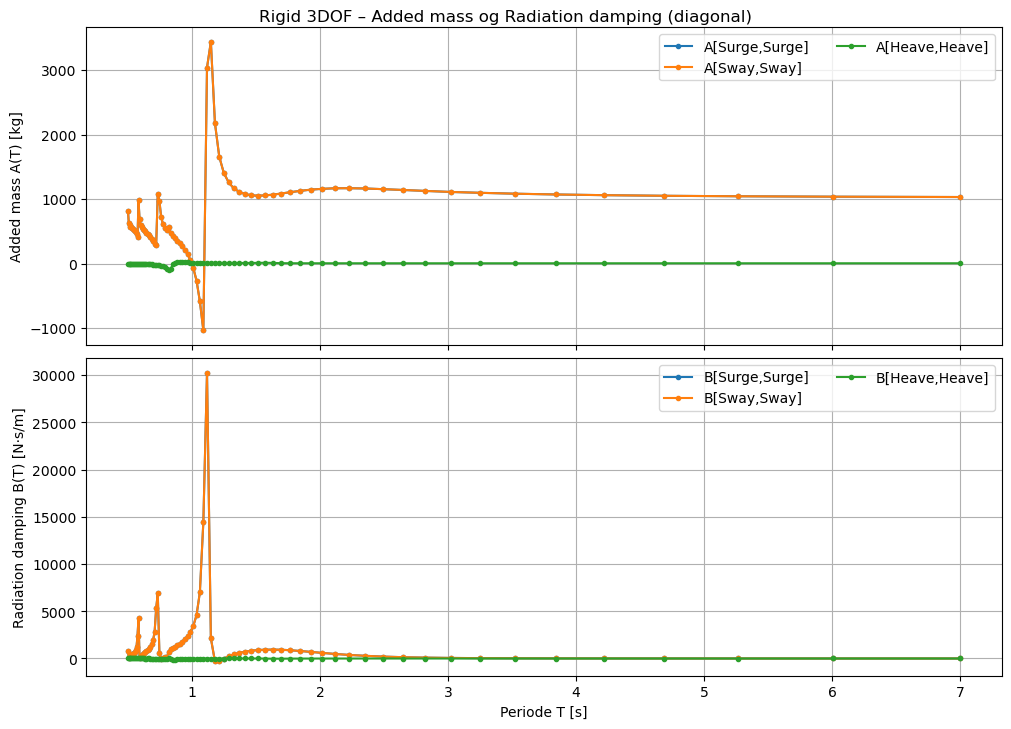

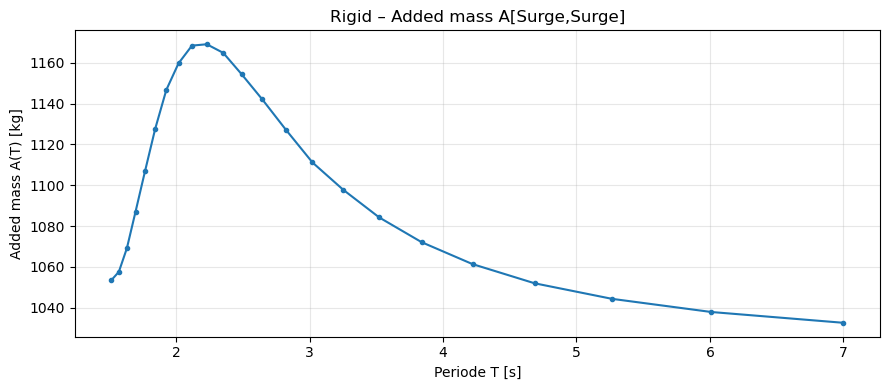

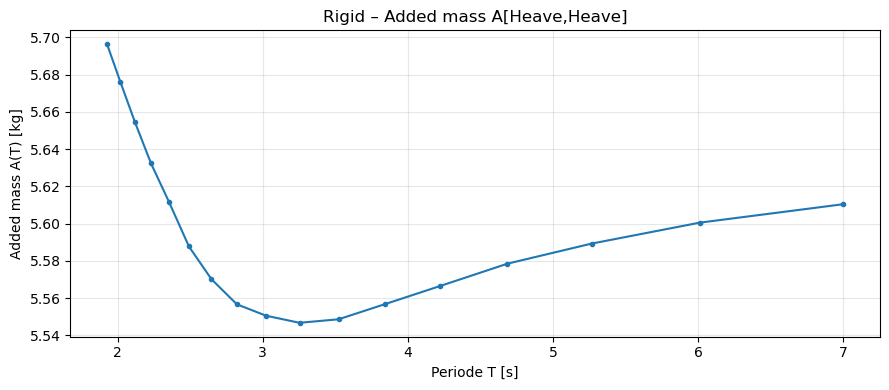

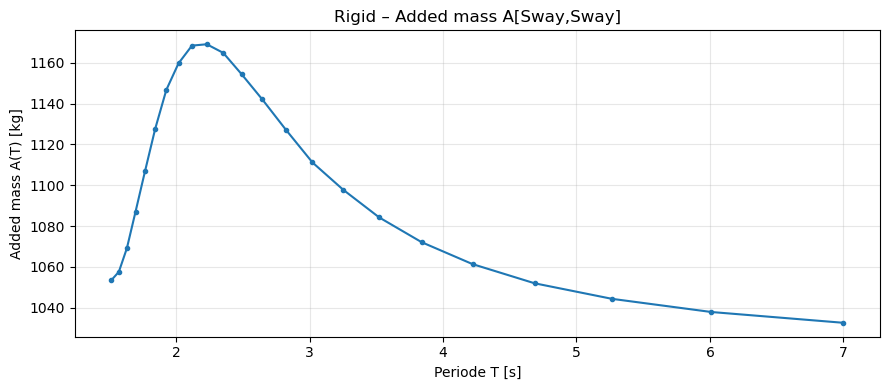

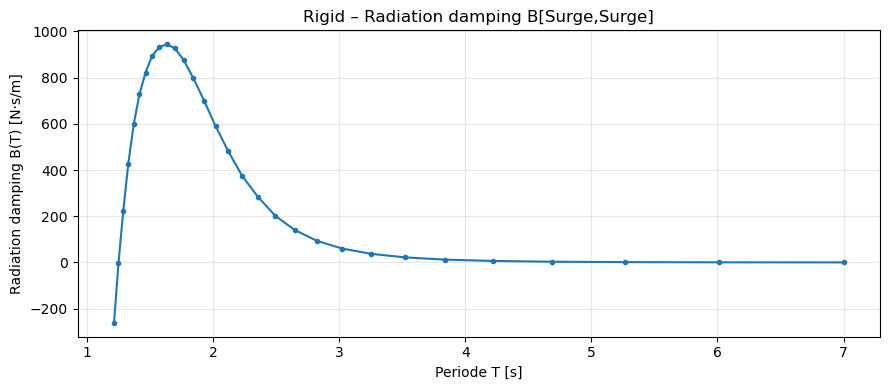

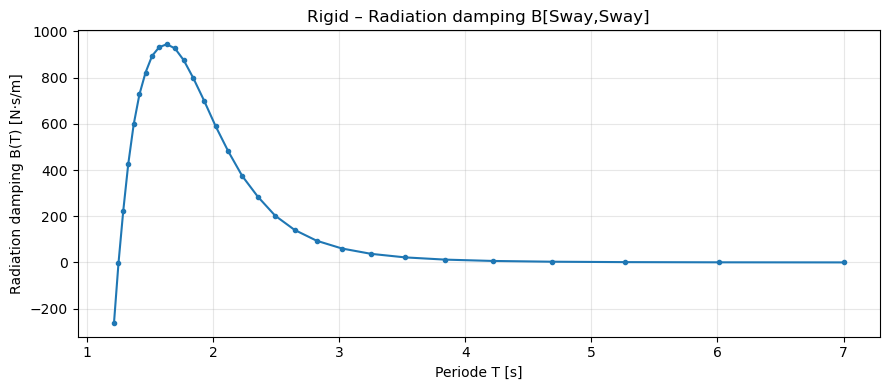

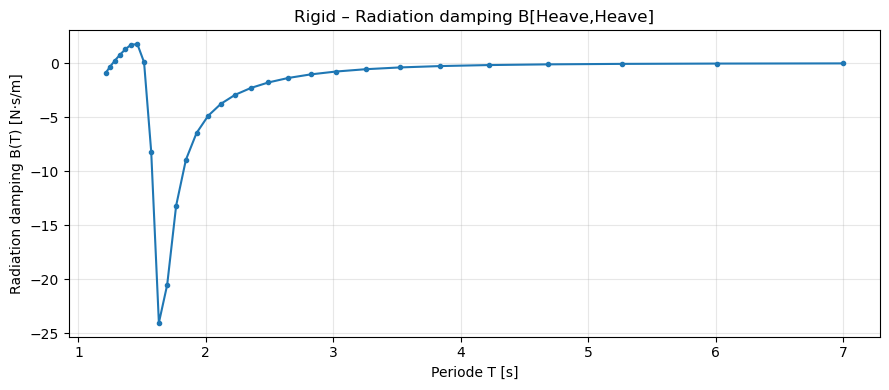

In [ ]:
# ---- plotter resultatet fra radiasjon for rigid body ---- 


import matplotlib.pyplot as plt

ds = rad_ds_rigid
dofs3 = ["Surge", "Sway", "Heave"]

# Robust string coords
try:
    ds = ds.assign_coords(radiating_dof=ds["radiating_dof"].astype(str))
    ds = ds.assign_coords(influenced_dof=ds["influenced_dof"].astype(str))
except Exception:
    pass

omega = np.asarray(ds["omega"].values, float)
T = 2*np.pi / omega

#sorter etter økende periode
idx = np.argsort(T)
T = T[idx]

# Hent full A(omega), B(omega) for 3x3
A_all = np.real(ds["added_mass"].sel(radiating_dof=dofs3, influenced_dof=dofs3).values)[idx, :, :]
B_all = np.real(ds["radiation_damping"].sel(radiating_dof=dofs3, influenced_dof=dofs3).values)[idx, :, :]

# Plot diagonalene
fig, ax = plt.subplots(2, 1, figsize=(10, 7), constrained_layout=True, sharex=True)
fig.suptitle("Rigid 3DOF – Added mass og Radiation damping (diagonal)", y=1.02)

for i, dof in enumerate(dofs3):
    ax[0].plot(T, A_all[:, i, i], "-o", ms=3, label=f"A[{dof},{dof}]")
ax[0].set_ylabel("Added mass A(T) [kg]")
ax[0].grid(True)
ax[0].legend(ncol=2)

for i, dof in enumerate(dofs3):
    ax[1].plot(T, B_all[:, i, i], "-o", ms=3, label=f"B[{dof},{dof}]")
ax[1].set_xlabel("Periode T [s]")
ax[1].set_ylabel("Radiation damping B(T) [N·s/m]")
ax[1].grid(True)
ax[1].legend(ncol=2)



def get_diag(varname: str, dof: str) -> np.ndarray:
    #Hent diagonalterm varname[dof,dof] sortert etter T.
    y = ds[varname].sel(radiating_dof=dof, influenced_dof=dof).values
    y = np.real(np.asarray(y, float))[idx]
    return y




maskT1 = (T >= 1.2) & (T <= 7.0) #1.2
maskT2= (T>=1.5) & (T<=7.0) #1.5
maskT3= (T>=1.9) & (T<=7.0) #1.9


# Data
A_surge = get_diag("added_mass", "Surge")
A_heave = get_diag("added_mass", "Heave")
A_sway = get_diag("added_mass", "Sway")
B_sway = get_diag("radiation_damping", "Sway")
B_surge = get_diag("radiation_damping", "Surge")
B_heave = get_diag("radiation_damping", "Heave")



#T_ref =1.1




# figurer hvor jeg klipper støy
# --- FIG 1: Added mass Surge ---
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(T[maskT2], A_surge[maskT2], "-o", ms=3)
ax.set_title("Rigid – Added mass A[Surge,Surge]")
ax.set_xlabel("Periode T [s]")
ax.set_ylabel("Added mass A(T) [kg]")
ax.grid(True, alpha=0.3)
fig.tight_layout()

# --- FIG 2: Added mass Heave ---
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(T[maskT3], A_heave[maskT3], "-o", ms=3)
ax.set_title("Rigid – Added mass A[Heave,Heave]")
ax.set_xlabel("Periode T [s]")
ax.set_ylabel("Added mass A(T) [kg]")
ax.grid(True, alpha=0.3)
fig.tight_layout()

# --- FIG : Added mass sway ---
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(T[maskT2], A_sway[maskT2], "-o", ms=3)
ax.set_title("Rigid – Added mass A[Sway,Sway]")
ax.set_xlabel("Periode T [s]")
ax.set_ylabel("Added mass A(T) [kg]")
ax.grid(True, alpha=0.3)
fig.tight_layout()



# --- FIG 3: Damping Surge ---
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(T[maskT1], B_surge[maskT1], "-o", ms=3)
ax.set_title("Rigid – Radiation damping B[Surge,Surge]")
ax.set_xlabel("Periode T [s]")
ax.set_ylabel("Radiation damping B(T) [N·s/m]")
ax.grid(True, alpha=0.3)
fig.tight_layout()

# --- FIG : Damping Sway ---
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(T[maskT1], B_sway[maskT1], "-o", ms=3)
ax.set_title("Rigid – Radiation damping B[Sway,Sway]")
ax.set_xlabel("Periode T [s]")
ax.set_ylabel("Radiation damping B(T) [N·s/m]")
ax.grid(True, alpha=0.3)
fig.tight_layout()


# --- FIG 4: Damping Heave ---
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(T[maskT1], B_heave[maskT1], "-o", ms=3)
#ax.axvline(T_ref, linestyle=":", linewidth=1.5, color="k", alpha=0.8)
ax.set_title("Rigid – Radiation damping B[Heave,Heave]")
ax.set_xlabel("Periode T [s]")
ax.set_ylabel("Radiation damping B(T) [N·s/m]")
ax.grid(True, alpha=0.3)
fig.tight_layout()

plt.show()



 Diffraction 4dof (m=2)

In [ ]:
# ---- samlet diffraksjon for rigid body og m=2 ----

import time, gc, os
import numpy as np
import capytaine as cpt

beta = 0.0
solver = cpt.BEMSolver()

# --- Sanity checks ---
needed = ["Surge", "Sway", "Heave", "Ovalization_m2"] #legge til surge, sway og heave
missing = [d for d in needed if d not in combined_body.dofs]
assert not missing, f"Diffraction: mangler DOFs på combined_body før solve: {missing}"

assert combined_body.dofs["Ovalization_m2"].shape == (combined_body.mesh.nb_faces, 3), \
    "Ovalization_m2 har feil shape ift immersed mesh."

omega_run = np.asarray(omega_run, float)
omega_run = omega_run[np.isfinite(omega_run)]
omega_run.sort()

# --- Build problems ---
diff_problems = [
    cpt.DiffractionProblem(body=combined_body, omega=float(w), wave_direction=beta, rho=rho)
    for w in omega_run
]

# --- Solve ---
t0 = time.time()
diff_results_4 = solver.solve_all(diff_problems, keep_details=False)
print(f"Diffraction (4DOF) ferdig på {time.time()-t0:.1f} s")

# --- Assemble + coords safe ---
diff_ds_4_m2 = ensure_str_coords(cpt.assemble_dataset(diff_results_4))
print(diff_ds_4_m2)

# --- Verify ovalization is present in excitation output ---
infl = list(diff_ds_4_m2["excitation_force"]["influenced_dof"].values)
assert "Ovalization_m2" in infl, f"Diffraction output mangler Ovalization_m2: {infl}"

# --- Save pickles ---
save_pickle(diff_ds_4_m2,  os.path.join(OUT_DIR, "diff_4dof_m2_T1p1to10_ds.pkl"))
save_pickle(diff_results_4, os.path.join(OUT_DIR, "diff_4dof_m2_T1p1to10_results.pkl"))

gc.collect()



[01:14:00] WARNING  Irregular frequencies for 49 problems:                                                         
                    Irregular frequencies might be encountered for omega ranging from 5.476 to 12.566.             
                    Setting a lid for the floating body is recommended.

c:\Users\ingfl\anaconda3\envs\waves\lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Diffraction (4DOF) ferdig på 3392.2 s
<xarray.Dataset> Size: 19kB
Dimensions:              (omega: 80, wave_direction: 1, influenced_dof: 4)
Coordinates:
    g                    float64 8B 9.81
    rho                  float64 8B 1e+03
    body_name            <U20 80B 'combined_flyter_pipe'
    water_depth          float64 8B inf
    forward_speed        float64 8B 0.0
  * omega                (omega) float64 640B 0.8976 1.045 1.193 ... 12.42 12.57
  * wave_direction       (wave_direction) float64 8B 0.0
    freq                 (omega) float64 640B 0.1429 0.1664 0.1899 ... 1.976 2.0
    period               (omega) float64 640B 7.0 6.011 5.267 ... 0.5059 0.5
    wavenumber           (omega) float64 640B 0.08213 0.1114 ... 15.72 16.1
    wavelength           (omega) float64 640B 76.5 56.41 43.31 ... 0.3997 0.3903
  * influenced_dof       (influenced_dof) <U14 224B 'Surge' ... 'Ovalization_m2'
Data variables:
    diffraction_force    (omega, wave_direction, influenced_dof) complex128 

33192

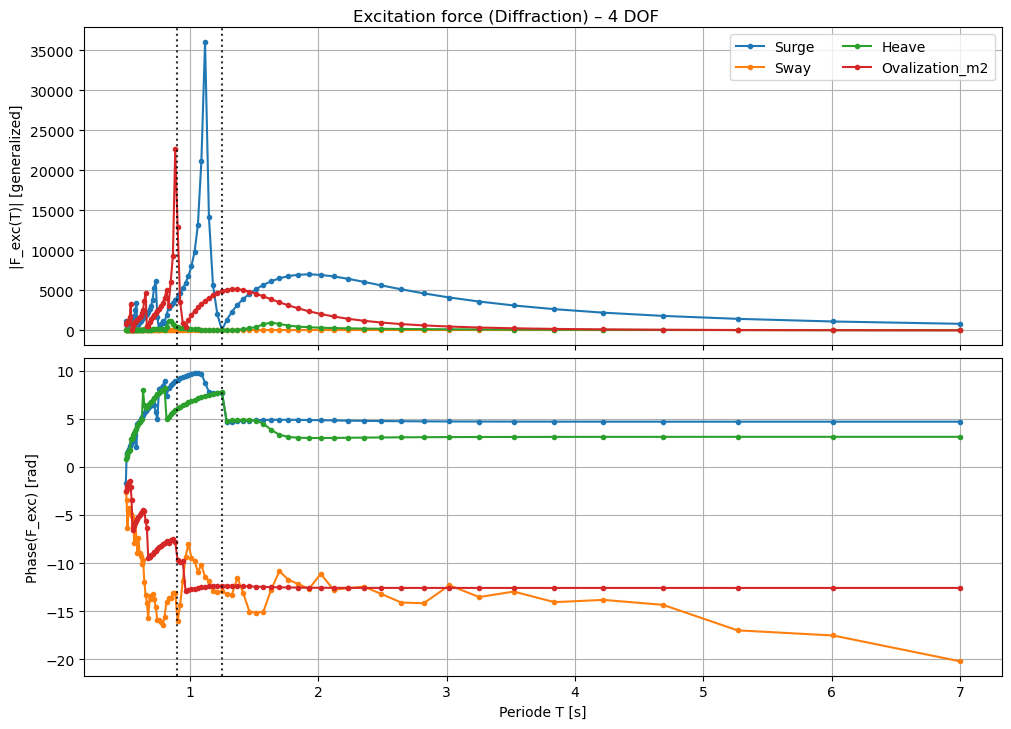

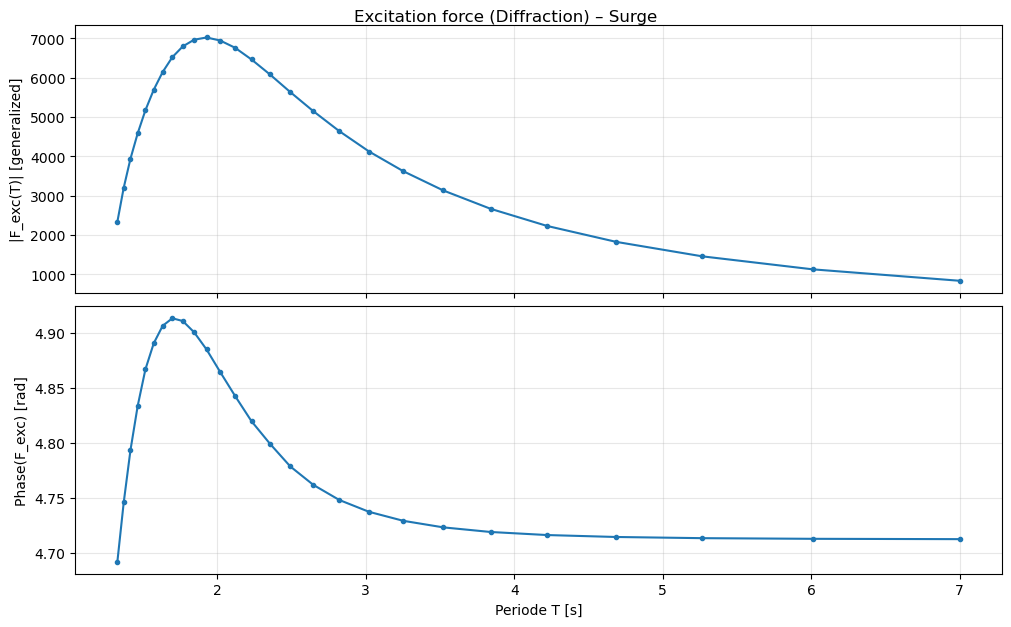

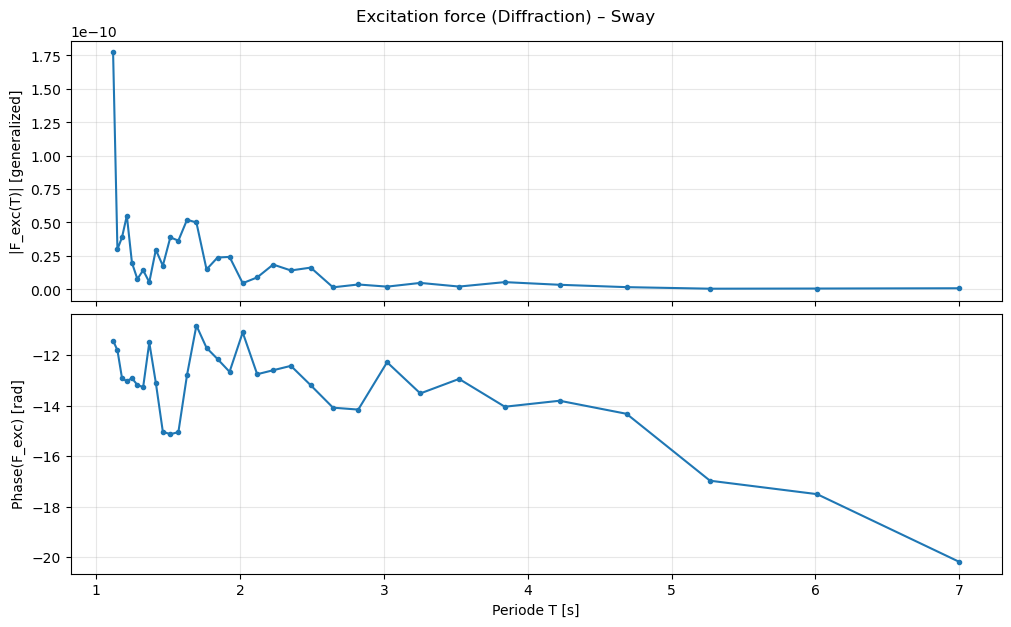

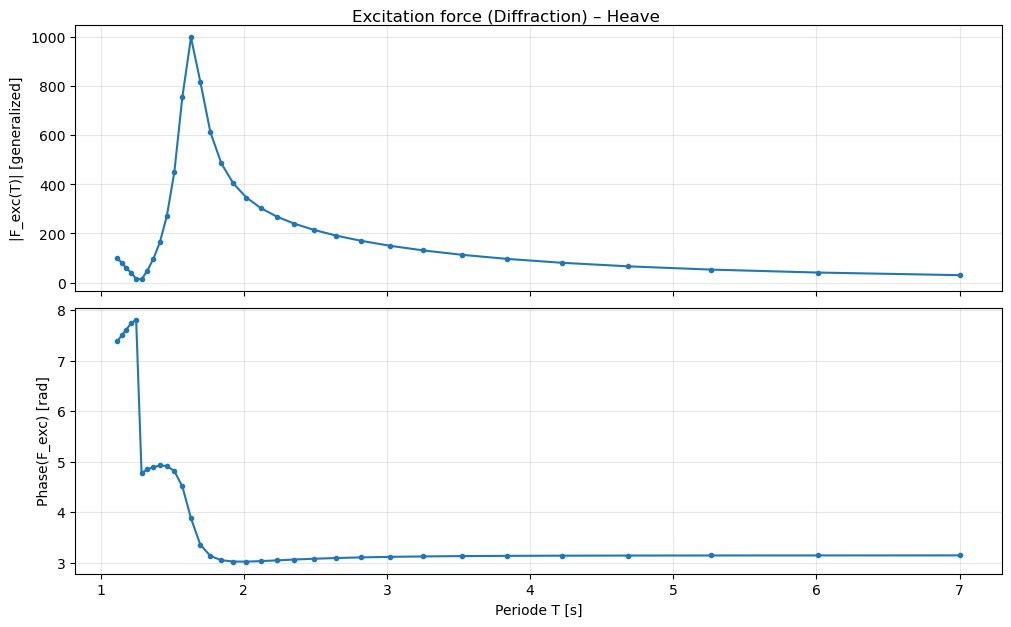

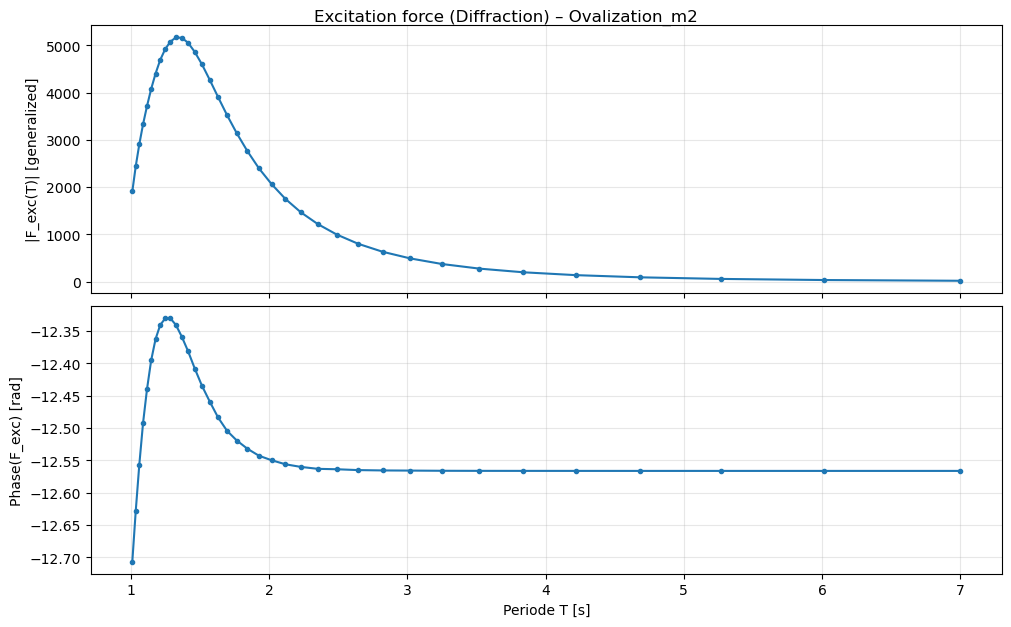

In [ ]:
# ---- plotter diffraksjon for rigid body og m=2 ----

import numpy as np
import matplotlib.pyplot as plt

ds = diff_ds_4_m2
dofs4 = ["Surge", "Sway", "Heave", "Ovalization_m2"] 

#velg excitation_force
F = ds["excitation_force"]
try:
    F = F.assign_coords(influenced_dof=F["influenced_dof"].astype(str))
except Exception:
    pass

#bølgeretning
beta_pick = 0.0
if "wave_direction" in F.dims:
    wd = np.asarray(F["wave_direction"].values, float)
    if np.any(wd == beta_pick):
        F = F.sel(wave_direction=beta_pick)
    else:
        i = int(np.argmin(np.abs(wd - beta_pick)))
        F = F.isel(wave_direction=i)


#omega og periode
omega = np.asarray(ds["omega"].values, float)
T = 2*np.pi / omega

# sortér på økende periode
idx = np.argsort(T)
T = T[idx]


# amplitude + fase (alle DOF-er)

fig, ax = plt.subplots(2, 1, figsize=(10, 7), constrained_layout=True, sharex=True)
fig.suptitle("Excitation force (Diffraction) – 4 DOF", y=1.02)

mask_surge = (T >= 1.3) & (T <= 10.0)
mask_sway  = (T >= 1.3) & (T <= 10.0)
mask_heave = (T >= 1.3) & (T <= 10.0)
mask_oval  = (T >= 0.8) & (T <= 10.0)

for dof in dofs4:
    Fi = np.asarray(F.sel(influenced_dof=str(dof)).values).squeeze().astype(complex)[idx]
    ax[0].plot(T, np.abs(Fi), "-o", ms=3, label=dof)
ax[0].set_ylabel("|F_exc(T)| [generalized]")
ax[0].grid(True)
ax[0].legend(ncol=2)

for dof in dofs4:
    Fi = np.asarray(F.sel(influenced_dof=str(dof)).values).squeeze().astype(complex)[idx]
    # unwrap gjør fasekurven mer lesbar
    ax[1].plot(T, np.unwrap(np.angle(Fi)), "-o", ms=3, label=dof)
ax[1].set_xlabel("Periode T [s]")
ax[1].set_ylabel("Phase(F_exc) [rad]")
ax[1].grid(True)

T_ref = 1.25
T_ref2 = 0.9

for a in ax:  # begge subplottene
    a.axvline(
        x=T_ref,
        linestyle=":",
        linewidth=1.5,
        color="k",
        alpha=0.8
    )
for a in ax:  # begge subplottene
    a.axvline(
        x=T_ref2,
        linestyle=":",
        linewidth=1.5,
        color="k",
        alpha=0.8
    )


plt.show()


# plotte én og én DOF, hjelpefunksjon
def get_F(dof: str) -> np.ndarray:
    #Hent kompleks excitation F_exc[dof] sortert etter T.
    Fi = np.asarray(F.sel(influenced_dof=str(dof)).values).squeeze().astype(complex)[idx]
    return Fi

# data (sortert)
F_surge = get_F("Surge")
F_sway  = get_F("Sway")
F_heave = get_F("Heave")
F_oval  = get_F("Ovalization_m2")


# masker (tilpasses per DOF)

mask_surge = (T >= 1.3) & (T <= 10.0)
mask_sway  = (T >= 1.1) & (T <= 10.0)
mask_heave = (T >= 1.1) & (T <= 10.0)
mask_oval  = (T >= 1.0) & (T <= 10.0)


# separate figurer per DOF (amplitude + fase)
def plot_F_one(dof_name: str, Fi: np.ndarray, mask: np.ndarray):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    fig.suptitle(f"Excitation force (Diffraction) – {dof_name}", y=1.02)

    ax[0].plot(T[mask], np.abs(Fi)[mask], "-o", ms=3)
    ax[0].set_ylabel("|F_exc(T)| [generalized]")
    ax[0].grid(True, alpha=0.3)

    ax[1].plot(T[mask], np.unwrap(np.angle(Fi))[mask], "-o", ms=3)
    ax[1].set_xlabel("Periode T [s]")
    ax[1].set_ylabel("Phase(F_exc) [rad]")
    ax[1].grid(True, alpha=0.3)

    plt.show()

plot_F_one("Surge", F_surge, mask_surge)
plot_F_one("Sway",  F_sway,  mask_sway)
plot_F_one("Heave", F_heave, mask_heave)
plot_F_one("Ovalization_m2", F_oval,  mask_oval)






 Radiation for ovalization mode m=2

In [9]:
# ---- radiasjon for modeshape med m=2 ----

solver = cpt.BEMSolver()
dofO = "Ovalization_m2"

radO_problems = [
    cpt.RadiationProblem(body=combined_body, radiating_dof=dofO, omega=float(w), rho=rho)
    for w in omega_run
]

t0 = time.time()
rad_results_O = solver.solve_all(radO_problems, keep_details=False)
print(f"Radiation O ferdig på {time.time()-t0:.1f} s")

rad_ds_O = ensure_str_coords(cpt.assemble_dataset(rad_results_O))
print(rad_ds_O)

save_pickle(rad_ds_O,  os.path.join(OUT_DIR, "rad_O_m2_T1p1to10_ds.pkl"))
save_pickle(rad_results_O, os.path.join(OUT_DIR, "rad_O_m2_T1p1to10_results.pkl"))
gc.collect()



[02:10:34] WARNING  Irregular frequencies for 49 problems:                                                         
                    Irregular frequencies might be encountered for omega ranging from 5.476 to 12.566.             
                    Setting a lid for the floating body is recommended.

c:\Users\ingfl\anaconda3\envs\waves\lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Radiation O ferdig på 3357.4 s
<xarray.Dataset> Size: 9kB
Dimensions:            (omega: 80, radiating_dof: 1, influenced_dof: 4)
Coordinates: (12/13)
    g                  float64 8B 9.81
    rho                float64 8B 1e+03
    body_name          <U20 80B 'combined_flyter_pipe'
    water_depth        float64 8B inf
    forward_speed      float64 8B 0.0
    wave_direction     float64 8B 0.0
    ...                 ...
    freq               (omega) float64 640B 0.1429 0.1664 0.1899 ... 1.976 2.0
    period             (omega) float64 640B 7.0 6.011 5.267 ... 0.512 0.5059 0.5
    wavenumber         (omega) float64 640B 0.08213 0.1114 0.1451 ... 15.72 16.1
    wavelength         (omega) float64 640B 76.5 56.41 43.31 ... 0.3997 0.3903
  * radiating_dof      (radiating_dof) <U14 56B 'Ovalization_m2'
  * influenced_dof     (influenced_dof) <U14 224B 'Surge' ... 'Ovalization_m2'
Data variables:
    added_mass         (omega, radiating_dof, influenced_dof) float64 3kB 9.4...
    radiatio

32421

m=2 forskyvning (radielt)

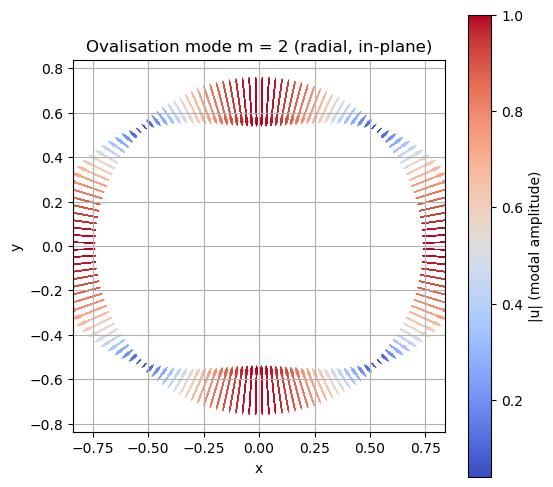

Max |tangential displacement|: 1.942890293094024e-16


In [ ]:
#---- visualiserer radiell forskyvning for m=2 ----

# Hent mesh-data 
mesh = combined_body.mesh
centers = mesh.faces_centers
x, y = centers[:, 0], centers[:, 1]

#Spesifiser DOF
u = combined_body.dofs["Ovalization_m2"]
ux, uy = u[:, 0].real, u[:, 1].real

# Amplitude 
amp = np.sqrt(ux**2 + uy**2)

plt.figure(figsize=(6,6))
plt.quiver(
    x, y,
    ux, uy,
    amp,
    angles="xy",
    scale_units="xy",
    scale=5,
    cmap="coolwarm"
)

plt.gca().set_aspect("equal")
plt.colorbar(label="|u| (modal amplitude)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Ovalisation mode m = 2 (radial, in-plane)")
plt.grid(True)
plt.show()


r = np.sqrt(x**2 + y**2)
erx, ery = x / r, y / r

# Tangentiell komponent
ut = -ux * ery + uy * erx

print("Max |tangential displacement|:", np.max(np.abs(ut)))



Radiation for kun m=2 plot

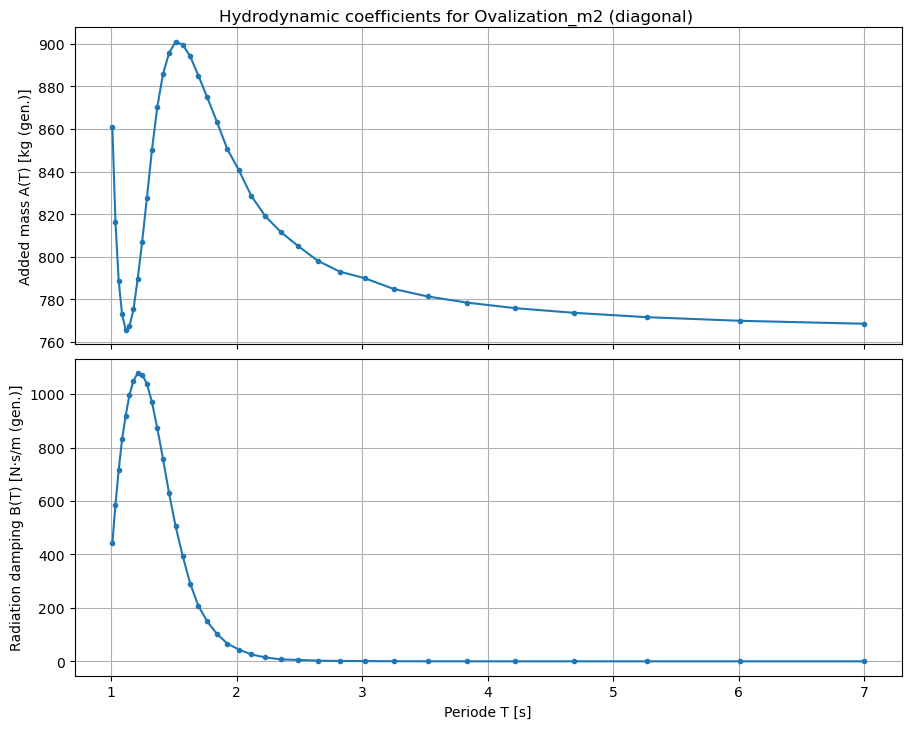

In [11]:
# ---- plotter radiasjon for m=2 ----

O = "Ovalization_m2"

# dataset fra Capytaine
radO = rad_ds_O

# gjør DOF-navn robuste
try:
    radO = radO.assign_coords(radiating_dof=radO["radiating_dof"].astype(str))
    radO = radO.assign_coords(influenced_dof=radO["influenced_dof"].astype(str))
except Exception:
    pass

#omega-grid gjøres om til periode
omega = np.asarray(radO["omega"].values, float)
T = 2*np.pi / omega

# henter ut added mass og demping for (O,O)
A = np.real(
    radO["added_mass"]
    .sel(radiating_dof=O, influenced_dof=O)
    .values
).astype(float)

B = np.real(
    radO["radiation_damping"]
    .sel(radiating_dof=O, influenced_dof=O)
    .values
).astype(float)

# sortér på økende periode 
idx = np.argsort(T)
T = T[idx]
A = A[idx]
B = B[idx]

TmaskO1 =(T >= 1.0)&(T<= 7.0)
TmaskO2 = (T >= 1.0)&(T <= 7.0)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(9, 7), constrained_layout=True, sharex=True)
fig.suptitle(f"Hydrodynamic coefficients for {O} (diagonal)", y=1.02)

ax[0].plot(T[TmaskO1], A[TmaskO1], "-o", ms=3)
ax[0].set_ylabel("Added mass A(T) [kg (gen.)]")
ax[0].grid(True)

ax[1].plot(T[TmaskO2], B[TmaskO2], "-o", ms=3)
ax[1].set_xlabel("Periode T [s]")
ax[1].set_ylabel("Radiation damping B(T) [N·s/m (gen.)]")
ax[1].grid(True)

plt.show()



In [12]:
# ---- løser koblet system for å vise "manglende" koblingsledd ----

"""
solver = cpt.BEMSolver()
dofs4 = ["Surge", "Sway", "Heave", "Ovalization_m2"]

rad4_problems = [
    cpt.RadiationProblem(body=combined_body, radiating_dof=rd, omega=float(w), rho=rho)
    for w in omega_run for rd in dofs4
]

t0 = time.time()
rad_results_4 = solver.solve_all(rad4_problems, keep_details=False)
print(f"Radiation 4DOF ferdig på {time.time()-t0:.1f} s")

rad_ds_4 = ensure_str_coords(cpt.assemble_dataset(rad_results_4))
print(rad_ds_4)

save_pickle(rad_ds_4,  os.path.join(OUT_DIR, "rad_4dof_m2_T1p1to10_ds.pkl"))
save_pickle(rad_results_4, os.path.join(OUT_DIR, "rad_4dof_m2_T1p1to10_results.pkl"))
gc.collect()
"""


'\nsolver = cpt.BEMSolver()\ndofs4 = ["Surge", "Sway", "Heave", "Ovalization_m2"]\n\nrad4_problems = [\n    cpt.RadiationProblem(body=combined_body, radiating_dof=rd, omega=float(w), rho=rho)\n    for w in omega_run for rd in dofs4\n]\n\nt0 = time.time()\nrad_results_4 = solver.solve_all(rad4_problems, keep_details=False)\nprint(f"Radiation 4DOF ferdig på {time.time()-t0:.1f} s")\n\nrad_ds_4 = ensure_str_coords(cpt.assemble_dataset(rad_results_4))\nprint(rad_ds_4)\n\nsave_pickle(rad_ds_4,  os.path.join(OUT_DIR, "rad_4dof_m2_T1p1to10_ds.pkl"))\nsave_pickle(rad_results_4, os.path.join(OUT_DIR, "rad_4dof_m2_T1p1to10_results.pkl"))\ngc.collect()\n'

Undersøke koblingsledd mellom surge-> ovalization, heave-> ovalization

In [13]:
# ---- plotter koblingsledd for heave -> ovalization, surge -> ovalization ----
"""
ds = rad_ds_4

O = "Ovalization_m2"
pairs = [("Heave", O), ("Surge", O)]  # legg til ("Sway", O) om du vil


try:
    ds = ds.assign_coords(radiating_dof=ds["radiating_dof"].astype(str))
    ds = ds.assign_coords(influenced_dof=ds["influenced_dof"].astype(str))
except Exception:
    pass


if "period" in ds.coords:
    T = np.asarray(ds["period"].values, float)
    omega = None
else:
    omega = np.asarray(ds["omega"].values, float)
    T = 2*np.pi / omega


idx = np.argsort(T)
T = T[idx]

def get_AB(radiating, influenced):
    A = ds["added_mass"].sel(radiating_dof=str(radiating), influenced_dof=str(influenced)).values
    B = ds["radiation_damping"].sel(radiating_dof=str(radiating), influenced_dof=str(influenced)).values
    A = np.real(np.asarray(A)).squeeze()[idx]
    B = np.real(np.asarray(B)).squeeze()[idx]
    return A, B


ncol = len(pairs)
fig, ax = plt.subplots(2, ncol, figsize=(5*ncol, 7), constrained_layout=True, sharex=True)
if ncol == 1:
    ax = np.array([[ax[0]], [ax[1]]])  # ensure 2D indexing

fig.suptitle("Coupling terms involving Ovalization_m2", y=1.02)

for j, (rd, inf) in enumerate(pairs):
    # forward (rd -> inf)
    A_f, B_f = get_AB(rd, inf)
    # reciprocal (inf -> rd)
    A_r, B_r = get_AB(inf, rd)

    # Added mass
    ax[0, j].plot(T, A_f, "-o", ms=3, label=f"{rd} → {inf}")
    ax[0, j].plot(T, A_r, "--o", ms=3, label=f"{inf} → {rd}")
    ax[0, j].set_title(f"Added mass coupling: {rd} ↔ {inf}")
    ax[0, j].set_ylabel("A [generalized]")
    ax[0, j].grid(True)
    ax[0, j].legend()

    # Radiation damping
    ax[1, j].plot(T, B_f, "-o", ms=3, label=f"{rd} → {inf}")
    ax[1, j].plot(T, B_r, "--o", ms=3, label=f"{inf} → {rd}")
    ax[1, j].set_title(f"Radiation damping coupling: {rd} ↔ {inf}")
    ax[1, j].set_xlabel("Periode T [s]")
    ax[1, j].set_ylabel("B [generalized]")
    ax[1, j].grid(True)
    ax[1, j].legend()

plt.show()
"""

'\nds = rad_ds_4\n\nO = "Ovalization_m2"\npairs = [("Heave", O), ("Surge", O)]  # legg til ("Sway", O) om du vil\n\n\ntry:\n    ds = ds.assign_coords(radiating_dof=ds["radiating_dof"].astype(str))\n    ds = ds.assign_coords(influenced_dof=ds["influenced_dof"].astype(str))\nexcept Exception:\n    pass\n\n\nif "period" in ds.coords:\n    T = np.asarray(ds["period"].values, float)\n    omega = None\nelse:\n    omega = np.asarray(ds["omega"].values, float)\n    T = 2*np.pi / omega\n\n\nidx = np.argsort(T)\nT = T[idx]\n\ndef get_AB(radiating, influenced):\n    A = ds["added_mass"].sel(radiating_dof=str(radiating), influenced_dof=str(influenced)).values\n    B = ds["radiation_damping"].sel(radiating_dof=str(radiating), influenced_dof=str(influenced)).values\n    A = np.real(np.asarray(A)).squeeze()[idx]\n    B = np.real(np.asarray(B)).squeeze()[idx]\n    return A, B\n\n\nncol = len(pairs)\nfig, ax = plt.subplots(2, ncol, figsize=(5*ncol, 7), constrained_layout=True, sharex=True)\nif ncol == 

## Definerer mode med m=3

In [14]:
# ---- defienrer mode m=3 ---- 

mesh = combined_body.mesh
centers = mesh.faces_centers
x, y, z = centers[:, 0], centers[:, 1], centers[:, 2]

r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)

m_mode = 3
dr = np.cos(m_mode * theta)
dr /= (np.max(np.abs(dr)) + 1e-14)

eps = 1e-12
r_safe = np.where(r < eps, eps, r)
ex, ey = x / r_safe, y / r_safe

ux = dr * ex
uy = dr * ey
uz = np.zeros_like(ux)

combined_body.dofs["Ovalization_m3"] = np.vstack((ux, uy, uz)).T.astype(complex)

print("DOFs:", list(combined_body.dofs.keys()))
assert combined_body.dofs["Ovalization_m3"].shape == (combined_body.mesh.nb_faces, 3)


DOFs: ['Surge', 'Sway', 'Heave', 'Ovalization_m2', 'Ovalization_m3']


## m=3 radiation

In [ ]:
# ---- radiasjon for m=3 ---- 


solver = cpt.BEMSolver()
dofO = "Ovalization_m3"

radO_problems = [
    cpt.RadiationProblem(body=combined_body, radiating_dof=dofO, omega=float(w), rho=rho)
    for w in omega_run
]

t0 = time.time()
rad_results_O3 = solver.solve_all(radO_problems, keep_details=False)
print(f"Radiation O ferdig på {time.time()-t0:.1f} s")

rad_ds_O3 = ensure_str_coords(cpt.assemble_dataset(rad_results_O3))
print(rad_ds_O3)

save_pickle(rad_ds_O3,  os.path.join(OUT_DIR, "rad_O_m3_T1p1to10_ds.pkl"))
save_pickle(rad_results_O, os.path.join(OUT_DIR, "rad_O_m3_T1p1to10_results.pkl"))
gc.collect()


[03:06:33] WARNING  Irregular frequencies for 49 problems:                                                         
                    Irregular frequencies might be encountered for omega ranging from 5.476 to 12.566.             
                    Setting a lid for the floating body is recommended.

c:\Users\ingfl\anaconda3\envs\waves\lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Radiation O ferdig på 3357.6 s
<xarray.Dataset> Size: 10kB
Dimensions:            (omega: 80, radiating_dof: 1, influenced_dof: 5)
Coordinates: (12/13)
    g                  float64 8B 9.81
    rho                float64 8B 1e+03
    body_name          <U20 80B 'combined_flyter_pipe'
    water_depth        float64 8B inf
    forward_speed      float64 8B 0.0
    wave_direction     float64 8B 0.0
    ...                 ...
    freq               (omega) float64 640B 0.1429 0.1664 0.1899 ... 1.976 2.0
    period             (omega) float64 640B 7.0 6.011 5.267 ... 0.512 0.5059 0.5
    wavenumber         (omega) float64 640B 0.08213 0.1114 0.1451 ... 15.72 16.1
    wavelength         (omega) float64 640B 76.5 56.41 43.31 ... 0.3997 0.3903
  * radiating_dof      (radiating_dof) <U14 56B 'Ovalization_m3'
  * influenced_dof     (influenced_dof) <U14 280B 'Surge' ... 'Ovalization_m3'
Data variables:
    added_mass         (omega, radiating_dof, influenced_dof) float64 3kB -1....
    radiati

19297

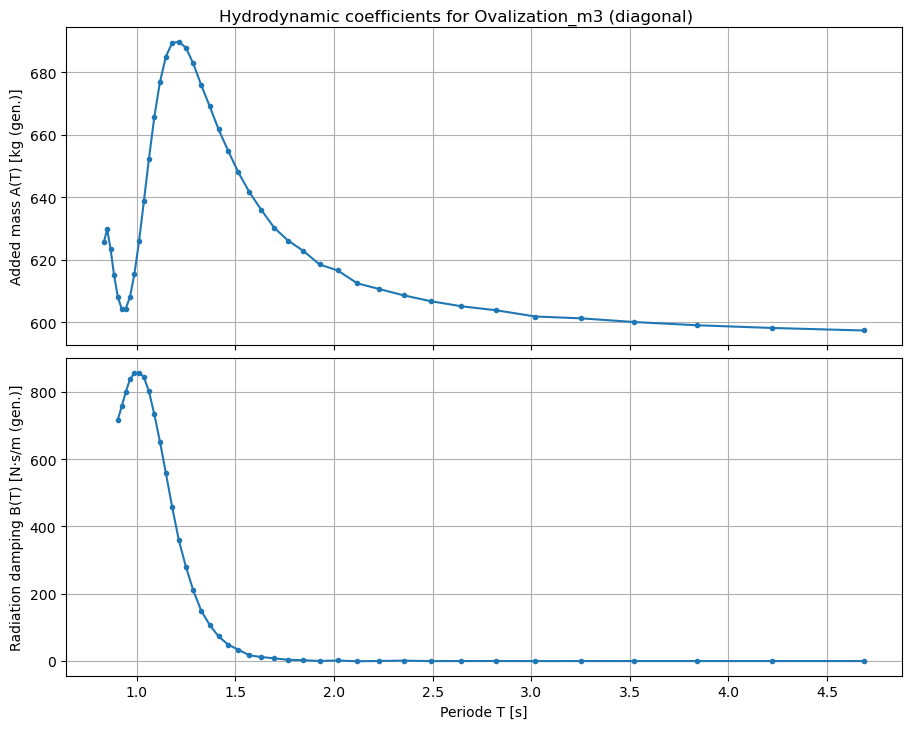

In [16]:
# ---- plot m=3 radiatsjon ---

#endre til riktig mode før den kjøres


O = "Ovalization_m3"

#henter datasett
radO = rad_ds_O

# gjør navn robuste
try:
    radO = radO.assign_coords(radiating_dof=radO["radiating_dof"].astype(str))
    radO = radO.assign_coords(influenced_dof=radO["influenced_dof"].astype(str))
except Exception:
    pass

# henter omega og gjør om til periode
omega = np.asarray(radO["omega"].values, float)
T = 2*np.pi / omega

# henter ut diagonal added mass og damping for moden
A = np.real(
    radO["added_mass"]
    .sel(radiating_dof=O, influenced_dof=O)
    .values
).astype(float)

B = np.real(
    radO["radiation_damping"]
    .sel(radiating_dof=O, influenced_dof=O)
    .values
).astype(float)

# sorter på økende periode
idx = np.argsort(T)
T = T[idx]
A = A[idx]
B = B[idx]

#cropper for å utelate numerisk støy
TmaskO1 =(T >= 0.82)&(T<= 5.0)
TmaskO2 = (T >= 0.9)&(T <= 5.0)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(9, 7), constrained_layout=True, sharex=True)
fig.suptitle(f"Hydrodynamic coefficients for {O} (diagonal)", y=1.02)

ax[0].plot(T[TmaskO1], A[TmaskO1], "-o", ms=3)
ax[0].set_ylabel("Added mass A(T) [kg (gen.)]")
ax[0].grid(True)

ax[1].plot(T[TmaskO2], B[TmaskO2], "-o", ms=3)
ax[1].set_xlabel("Periode T [s]")
ax[1].set_ylabel("Radiation damping B(T) [N·s/m (gen.)]")
ax[1].grid(True)

plt.show()

## m=3 diffraction only

In [ ]:

#  Diffraction – kun Ovalization_m3 (for modal RAO m=3)

import time, gc, os
import numpy as np
import capytaine as cpt

beta = 0.0
solver = cpt.BEMSolver()

# --- Sanity checks ---
needed = ["Ovalization_m3"]
missing = [d for d in needed if d not in combined_body.dofs]
assert not missing, f"Diffraction: mangler DOFs på combined_body før solve: {missing}"

assert combined_body.dofs["Ovalization_m3"].shape == (combined_body.mesh.nb_faces, 3), \
    "Ovalization_m3 har feil shape ift immersed mesh."

# --- Omega grid ---
omega_run = np.asarray(omega_run, float)
omega_run = omega_run[np.isfinite(omega_run)]
omega_run.sort()


diff_problems = [
    cpt.DiffractionProblem(body=combined_body, omega=float(w), wave_direction=float(beta), rho=rho)
    for w in omega_run
]

# --- Solve ---
t0 = time.time()
diff_results_m3 = solver.solve_all(diff_problems, keep_details=False)
print(f"Diffraction (kun m=3) ferdig på {time.time()-t0:.1f} s")

# --- Assemble ----
diff_ds_m2 = ensure_str_coords(cpt.assemble_dataset(diff_results_m2))
print(diff_ds_m2)

# --- Verify ovalization is present in excitation output ---
infl = list(diff_ds_m2["excitation_force"]["influenced_dof"].values)
assert "Ovalization_m2" in infl, f"Diffraction output mangler Ovalization_m2: {infl}"

# --- Save pickles ---
save_pickle(diff_ds_m3,  os.path.join(OUT_DIR, "diff_m3_T1p1to10_ds.pkl"))
save_pickle(diff_results_m3, os.path.join(OUT_DIR, "diff_m3_T1p1to10_results.pkl"))

gc.collect()


## Diffraction 4DOF med m=3

In [ ]:

import time, gc
import capytaine as cpt
import numpy as np

beta = 0.0 #sett til 0 for head sea, np.pi/4 = 90, /8=45 grader
solver = cpt.BEMSolver()

omega_run = np.asarray(omega_run, float)
omega_run = omega_run[np.isfinite(omega_run)]
omega_run.sort()

diff_problems_m3 = [
    cpt.DiffractionProblem(body=combined_body, omega=float(w), wave_direction=beta, rho=rho)
    for w in omega_run
]

t0 = time.time()
diff_results_4_m3 = solver.solve_all(diff_problems_m3, keep_details=False)
print(f"Diffraction 4DOF (m=3) ferdig på {time.time()-t0:.1f} s")

diff_ds_4_m3 = ensure_str_coords(cpt.assemble_dataset(diff_results_4_m3))
print(diff_ds_4_m3)

gc.collect()


[04:02:32] WARNING  Irregular frequencies for 49 problems:                                                         
                    Irregular frequencies might be encountered for omega ranging from 5.476 to 12.566.             
                    Setting a lid for the floating body is recommended.

c:\Users\ingfl\anaconda3\envs\waves\lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Diffraction 4DOF (m=3) ferdig på 3354.4 s
<xarray.Dataset> Size: 23kB
Dimensions:              (omega: 80, wave_direction: 1, influenced_dof: 5)
Coordinates:
    g                    float64 8B 9.81
    rho                  float64 8B 1e+03
    body_name            <U20 80B 'combined_flyter_pipe'
    water_depth          float64 8B inf
    forward_speed        float64 8B 0.0
  * omega                (omega) float64 640B 0.8976 1.045 1.193 ... 12.42 12.57
  * wave_direction       (wave_direction) float64 8B 0.0
    freq                 (omega) float64 640B 0.1429 0.1664 0.1899 ... 1.976 2.0
    period               (omega) float64 640B 7.0 6.011 5.267 ... 0.5059 0.5
    wavenumber           (omega) float64 640B 0.08213 0.1114 ... 15.72 16.1
    wavelength           (omega) float64 640B 76.5 56.41 43.31 ... 0.3997 0.3903
  * influenced_dof       (influenced_dof) <U14 280B 'Surge' ... 'Ovalization_m3'
Data variables:
    diffraction_force    (omega, wave_direction, influenced_dof) complex

7433

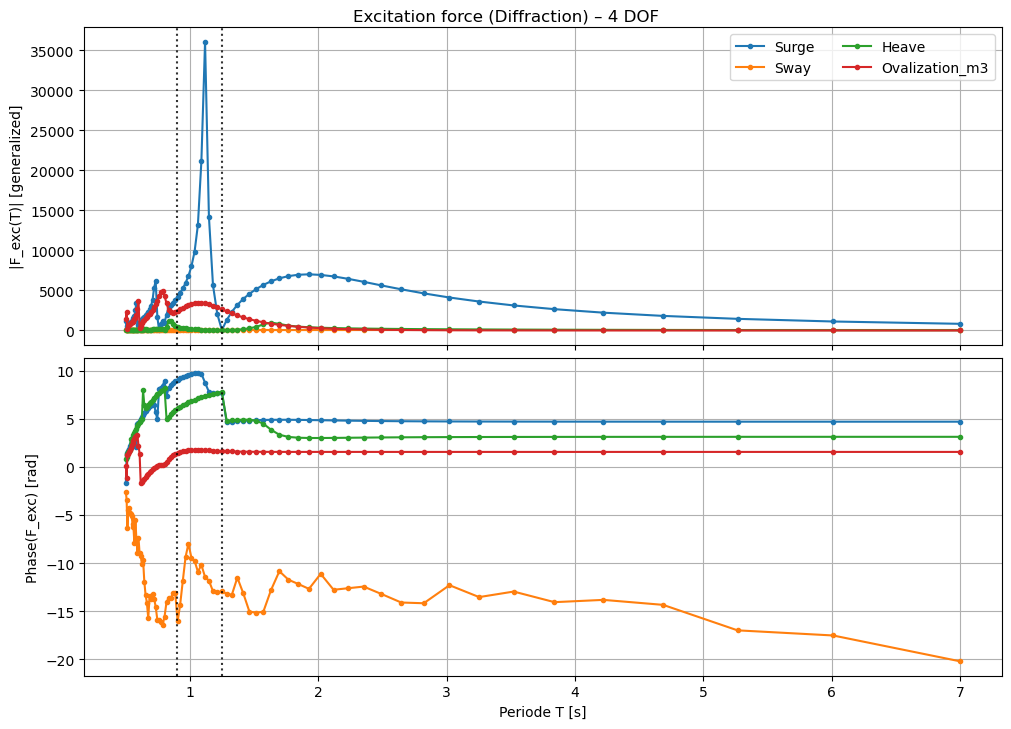

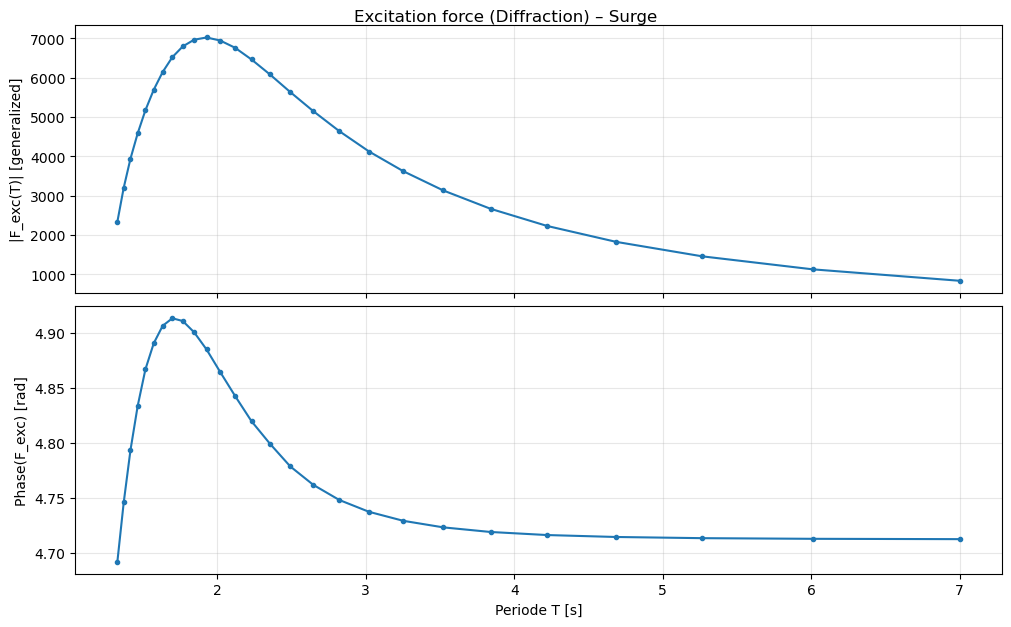

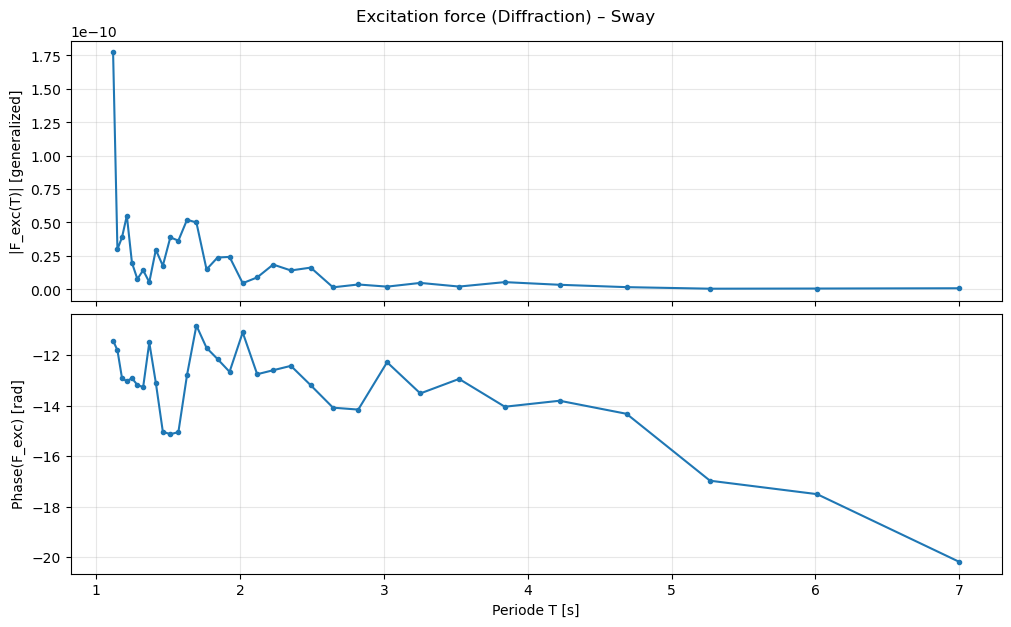

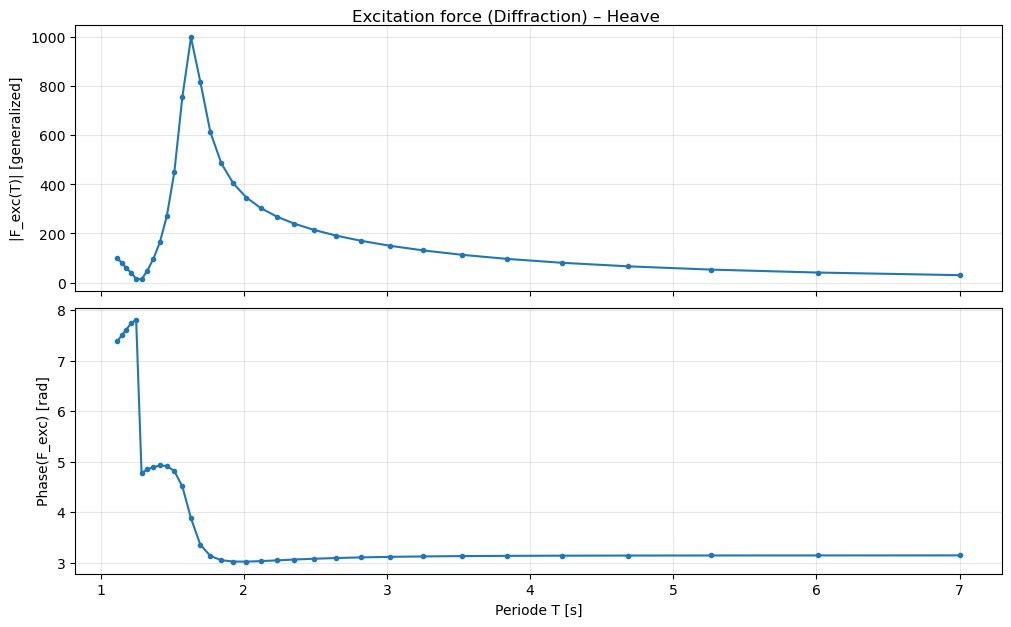

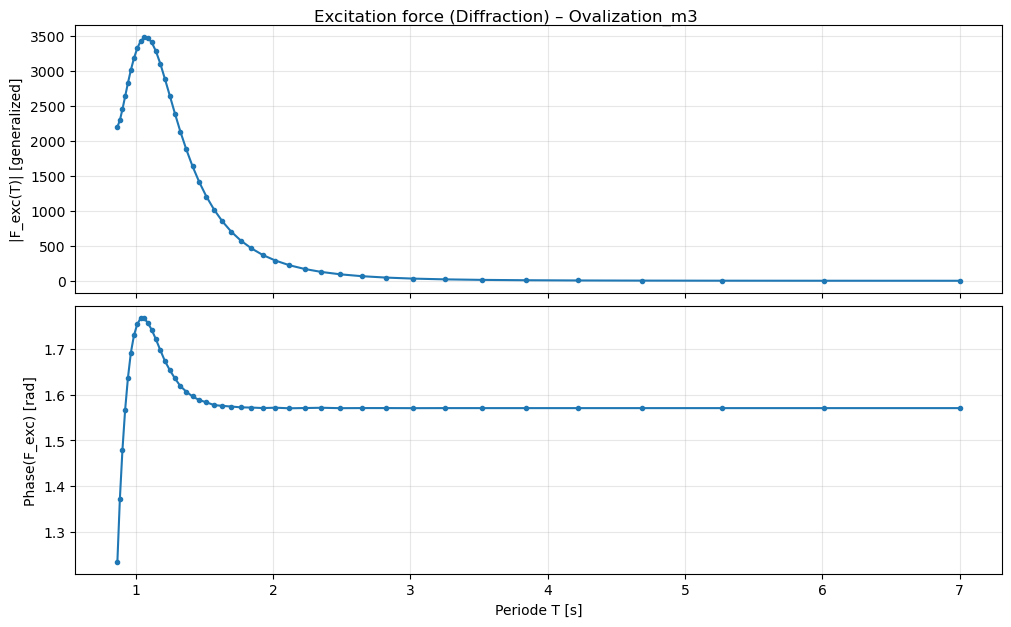

In [26]:
# ---- plotter diffraksjon for rigid body og m=3 ----

import numpy as np
import matplotlib.pyplot as plt

ds = diff_ds_4_m3
dofs4 = ["Surge", "Sway", "Heave", "Ovalization_m3"]

#velg excitation_force
F = ds["excitation_force"]
try:
    F = F.assign_coords(influenced_dof=F["influenced_dof"].astype(str))
except Exception:
    pass

#bølgeretning
beta_pick = 0.0
if "wave_direction" in F.dims:
    wd = np.asarray(F["wave_direction"].values, float)
    if np.any(wd == beta_pick):
        F = F.sel(wave_direction=beta_pick)
    else:
        i = int(np.argmin(np.abs(wd - beta_pick)))
        F = F.isel(wave_direction=i)


#omega og periode
omega = np.asarray(ds["omega"].values, float)
T = 2*np.pi / omega

# sortér på økende periode
idx = np.argsort(T)
T = T[idx]


# amplitude + fase (alle DOF-er)

fig, ax = plt.subplots(2, 1, figsize=(10, 7), constrained_layout=True, sharex=True)
fig.suptitle("Excitation force (Diffraction) – 4 DOF", y=1.02)

mask_surge = (T >= 1.3) & (T <= 10.0)
mask_sway  = (T >= 1.3) & (T <= 10.0)
mask_heave = (T >= 1.3) & (T <= 10.0)
mask_oval  = (T >= 0.8) & (T <= 10.0)

for dof in dofs4:
    Fi = np.asarray(F.sel(influenced_dof=str(dof)).values).squeeze().astype(complex)[idx]
    ax[0].plot(T, np.abs(Fi), "-o", ms=3, label=dof)
ax[0].set_ylabel("|F_exc(T)| [generalized]")
ax[0].grid(True)
ax[0].legend(ncol=2)

for dof in dofs4:
    Fi = np.asarray(F.sel(influenced_dof=str(dof)).values).squeeze().astype(complex)[idx]
    # unwrap gjør fasekurven mer lesbar
    ax[1].plot(T, np.unwrap(np.angle(Fi)), "-o", ms=3, label=dof)
ax[1].set_xlabel("Periode T [s]")
ax[1].set_ylabel("Phase(F_exc) [rad]")
ax[1].grid(True)

T_ref = 1.25
T_ref2 = 0.9

for a in ax:  # begge subplottene
    a.axvline(
        x=T_ref,
        linestyle=":",
        linewidth=1.5,
        color="k",
        alpha=0.8
    )
for a in ax:  # begge subplottene
    a.axvline(
        x=T_ref2,
        linestyle=":",
        linewidth=1.5,
        color="k",
        alpha=0.8
    )


plt.show()


# plotte én og én DOF, hjelpefunksjon
def get_F(dof: str) -> np.ndarray:
    #Hent kompleks excitation F_exc[dof] sortert etter T.
    Fi = np.asarray(F.sel(influenced_dof=str(dof)).values).squeeze().astype(complex)[idx]
    return Fi

# data (sortert)
F_surge = get_F("Surge")
F_sway  = get_F("Sway")
F_heave = get_F("Heave")
F_oval  = get_F("Ovalization_m3")


# masker

mask_surge = (T >= 1.3) & (T <= 10.0)
mask_sway  = (T >= 1.1) & (T <= 10.0)
mask_heave = (T >= 1.1) & (T <= 10.0)
mask_oval  = (T >= 0.85) & (T <= 10.0)


# separate figurer per DOF (amplitude + fase)
def plot_F_one(dof_name: str, Fi: np.ndarray, mask: np.ndarray):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    fig.suptitle(f"Excitation force (Diffraction) – {dof_name}", y=1.02)

    ax[0].plot(T[mask], np.abs(Fi)[mask], "-o", ms=3)
    ax[0].set_ylabel("|F_exc(T)| [generalized]")
    ax[0].grid(True, alpha=0.3)

    ax[1].plot(T[mask], np.unwrap(np.angle(Fi))[mask], "-o", ms=3)
    ax[1].set_xlabel("Periode T [s]")
    ax[1].set_ylabel("Phase(F_exc) [rad]")
    ax[1].grid(True, alpha=0.3)

    plt.show()

plot_F_one("Surge", F_surge, mask_surge)
plot_F_one("Sway",  F_sway,  mask_sway)
plot_F_one("Heave", F_heave, mask_heave)
plot_F_one("Ovalization_m3", F_oval,  mask_oval)


 RAO rigid + m=2

## RAO 3DOF

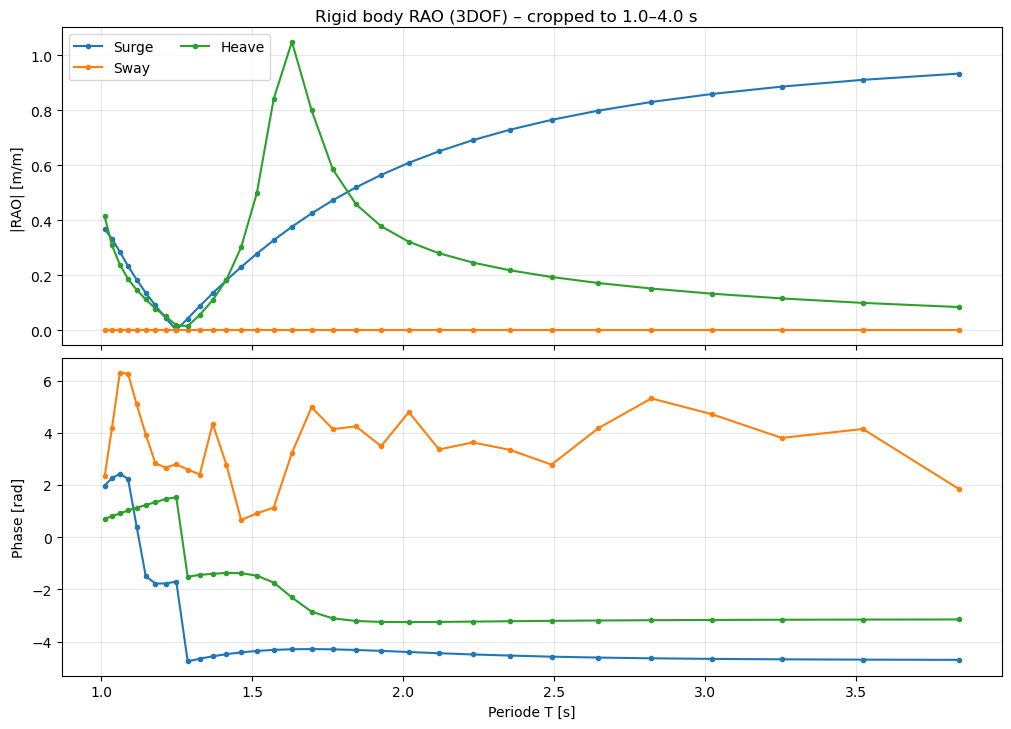

In [27]:
# ---- RAO heave, surge, sway ---- 

beta_pick = 0.0
dofs3 = ["Surge", "Sway", "Heave"] 

# robuste string coords. 
dsR = rad_ds_rigid
try:
    dsR = dsR.assign_coords(radiating_dof=dsR["radiating_dof"].astype(str))
    dsR = dsR.assign_coords(influenced_dof=dsR["influenced_dof"].astype(str))
except Exception:
    pass

dsD = diff_ds_4_m2
F = dsD["excitation_force"]
try:
    F = F.assign_coords(influenced_dof=F["influenced_dof"].astype(str))
except Exception:
    pass

#omega grid
omega = np.asarray(omega_run, float)
omega = omega[np.isfinite(omega)]
omega.sort()
T = 2*np.pi / omega

#hent A,B på omega 
A_rr = np.real(dsR["added_mass"].sel(radiating_dof=dofs3, influenced_dof=dofs3).sel(omega=omega).values)
B_rr = np.real(dsR["radiation_damping"].sel(radiating_dof=dofs3, influenced_dof=dofs3).sel(omega=omega).values)

# Velg wave_direction (mulig)
if "wave_direction" in F.dims:
    wd = np.asarray(F["wave_direction"].values, float)
    if np.any(wd == beta_pick):
        F = F.sel(wave_direction=beta_pick)
    else:
        i = int(np.argmin(np.abs(wd - beta_pick)))
        F = F.isel(wave_direction=i)

# excitation vector
F_r = []
for d in dofs3:
    Fi = np.asarray(F.sel(influenced_dof=d).values).squeeze().astype(complex)
    F_r.append(Fi)
F_r = np.column_stack(F_r) 


# Rigid structural/hydrostatic modell

g = 9.81
M_ring = 2.84 #[kg]

# Fyll inn disse:
m_rigid = float(M_ring)   # [kg] rigid-body masse (sett riktig verdi)
A_wp =  A_wp = 4*np.pi*R_ring*r_pipe 
K33  = rho*9.81*A_wp          # [m^2] vannplanareal (sett riktig verdi)

M_r = np.diag([m_rigid, m_rigid, m_rigid])
C_r = np.zeros((3,3))
K_r = np.diag([24.0, 24.0, float(rho)*g*A_wp])  # heave restoring pluss 


# solve RAO
X = np.zeros((len(omega), 3), dtype=complex)

for k, w in enumerate(omega):
    Z = -(w**2)*(M_r + A_rr[k]) + 1j*w*(C_r + B_rr[k]) + K_r
    X[k] = np.linalg.solve(Z, F_r[k])

# sorter for økende periode
idx = np.argsort(T)
T_plot = T[idx]
X_plot = X[idx]


# Crop: velg fysisk meningsfullt intervall
Tmin = 1.0   
Tmax = 4.0
maskT = (T_plot >= Tmin) & (T_plot <= Tmax)

T_c = T_plot[maskT]
X_c = X_plot[maskT, :]



# plots: amplitude + phase (croppet)
fig, ax = plt.subplots(2, 1, figsize=(10, 7), constrained_layout=True, sharex=True)
fig.suptitle(f"Rigid body RAO (3DOF) – cropped to {Tmin:.1f}–{Tmax:.1f} s", y=1.02)

for i, d in enumerate(dofs3):
    ax[0].plot(T_c, np.abs(X_c[:, i]), "-o", ms=3, label=d)
ax[0].set_ylabel("|RAO| [m/m] ")
ax[0].grid(True, alpha=0.3)
ax[0].legend(ncol=2)

# phase: unwrap gjør kurvene mindre “hoppete”, særlig nyttig når amplitude er liten
for i, d in enumerate(dofs3):
    ax[1].plot(T_c, np.unwrap(np.angle(X_c[:, i])), "-o", ms=3, label=d)
ax[1].set_xlabel("Periode T [s]")
ax[1].set_ylabel("Phase [rad]")
ax[1].grid(True, alpha=0.3)

plt.show()

# RAO-resultat tilbake til notebooken (fullt)
RAO_rigid = X


 Ferdig med undersøkeler ^

## Ovalization RAO m=2

In [ ]:


# --- Inputs som må være i minnet ---
# omega_run, rho
# rad_ds_O  (1DOF radiation for Ovalization_m2)  ELLER rad_ds_4 (4DOF)
# diff_ds_4_m2  (diffraction med excitation for Ovalization_m2)
# R_ring, mu (m2D), EI


#ENDRE SÅNN AT DEN BRUKER OVALIZATION RADIATION IKKE 4DOF

beta_pick = 0.0
O = "Ovalization_m2"
m = 2

# --- omega / T ---
omega = np.asarray(omega_run, float)
omega = omega[np.isfinite(omega)]
omega.sort()
T = 2*np.pi/omega
idx = np.argsort(T)
omega = omega[idx]
T = T[idx]


E = 1000e6  # [Pa] 1000 MPa
I = (np.pi/64.0) * (0.025**4 - 0.021**4)  # [m^4]
EI = E * I

# --- Structural generalized terms  ---
R = float(R_ring)
#m2D = float(mu)
EI_loc = float(EI)

mu=M_ring/(2*np.pi*R)
#R = float(R_ring)
m2D = float(mu)  
#M_gen = m2D * np.pi * R

M_gen = 0.5*M_ring
lam = (m**2 * (m**2 - 1)) / (R**4)
K_gen = EI_loc * lam * (np.pi * R)

# Optional structural damping 
zeta = 0.01
C_gen = 2*zeta*np.sqrt(K_gen*M_gen)

# --- Hydrodynamics A_OO, B_OO on omega grid ---
# Prefer rad_ds_O if available; otherwise take diagonal from rad_ds_4
if "rad_ds_O" in globals():
    rad = rad_ds_O
    try:
        rad = rad.assign_coords(radiating_dof=rad["radiating_dof"].astype(str))
        rad = rad.assign_coords(influenced_dof=rad["influenced_dof"].astype(str))
    except Exception:
        pass
    A_OO = np.real(rad["added_mass"].sel(radiating_dof=O, influenced_dof=O).sel(omega=omega).values).astype(float)
    B_OO = np.real(rad["radiation_damping"].sel(radiating_dof=O, influenced_dof=O).sel(omega=omega).values).astype(float)
else:
    rad = rad_ds_O
    try:
        rad = rad.assign_coords(radiating_dof=rad["radiating_dof"].astype(str))
        rad = rad.assign_coords(influenced_dof=rad["influenced_dof"].astype(str))
    except Exception:
        pass
    A_OO = np.real(rad["added_mass"].sel(radiating_dof=O, influenced_dof=O).sel(omega=omega).values).astype(float)
    B_OO = np.real(rad["radiation_damping"].sel(radiating_dof=O, influenced_dof=O).sel(omega=omega).values).astype(float)

# --- Excitation F_O(omega) ---
diff = diff_ds_4_m2
F = diff["excitation_force"]
try:
    F = F.assign_coords(influenced_dof=F["influenced_dof"].astype(str))
except Exception:
    pass

if "wave_direction" in F.dims:
    wd = np.asarray(F["wave_direction"].values, float)
    if np.any(wd == beta_pick):
        F = F.sel(wave_direction=beta_pick)
    else:
        i = int(np.argmin(np.abs(wd - beta_pick)))
        F = F.isel(wave_direction=i)

F_O = np.asarray(F.sel(influenced_dof=O).sel(omega=omega).values).squeeze().astype(complex)

# --- Solve 1DOF RAO ---
Z = -(omega**2)*(M_gen + A_OO) + 1j*omega*(C_gen + B_OO) + K_gen
qO = F_O / Z

# --- Plot ---
fig, ax = plt.subplots(2, 1, figsize=(9, 7), constrained_layout=True, sharex=True)
fig.suptitle("RAO – Ovalization m=2 (1DOF)", y=1.02)

ax[0].plot(T, np.abs(qO), "-o", ms=3)
ax[0].set_ylabel("|q_O|")
ax[0].grid(True)

ax[1].plot(T, np.angle(qO), "-o", ms=3)
ax[1].set_xlabel("Periode T [s]")
ax[1].set_ylabel("Phase(q_O) [rad]")
ax[1].grid(True)

plt.show()

RAO_m2_uncoupled = qO

KeyError: "not all values found in index 'radiating_dof'. Try setting the `method` keyword argument (example: method='nearest')."

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Inputs som må være i minnet:
# omega_run, rho
# rad_ds_O            # radiation for Ovalization_m2 (anbefalt)
# diff_ds_4_m2        # diffraction som inneholder excitation for Ovalization_m2
# R_ring, M_ring, r_pipe (hvis du bruker den i A_wp etc.)


beta_pick = 0.0
O = "Ovalization_m2"
m = 2

# --- omega / T (sortert på økende periode) ---
omega = np.asarray(omega_run, float)
omega = omega[np.isfinite(omega)]
omega.sort()
T = 2*np.pi / omega

idx = np.argsort(T)
omega = omega[idx]
T = T[idx]


# Structural generalized terms 

E = 1000e6  # [Pa]
I = (np.pi/64.0) * (0.025**4 - 0.021**4)  # [m^4] (sjekk 
EI = E * I

R = float(R_ring)

# Lineær masse per lengde :
mu = float(M_ring) / (2*np.pi*R)

# NB: M_gen avhenger av normalisering/definisjon av modeshape.

M_gen = 0.5 * float(M_ring)

lam = (m**2 * (m**2 - 1)) / (R**4)
K_gen = float(EI) * lam * (np.pi * R)

# Valgfri strukturell demping
zeta = 0.01
C_gen = 2*zeta*np.sqrt(K_gen*M_gen)


# Hydrodynamics: A_OO, B_OO fra ovalization-radiation

if "rad_ds_O" not in globals():
    raise NameError("rad_ds_O finnes ikke i minnet. Kjør ovalization-radiation (1DOF) først og lag rad_ds_O.")

rad = rad_ds_O
try:
    rad = rad.assign_coords(
        radiating_dof=rad["radiating_dof"].astype(str),
        influenced_dof=rad["influenced_dof"].astype(str),
    )
except Exception:
    pass

# Hent og align på omega
A_OO = np.real(
    rad["added_mass"].sel(radiating_dof=O, influenced_dof=O).sel(omega=omega).values
).astype(float)

B_OO = np.real(
    rad["radiation_damping"].sel(radiating_dof=O, influenced_dof=O).sel(omega=omega).values
).astype(float)


# Excitation: F_O(omega) fra diffraction

diff = diff_ds_4_m2
F = diff["excitation_force"]
try:
    F = F.assign_coords(influenced_dof=F["influenced_dof"].astype(str))
except Exception:
    pass

if "wave_direction" in F.dims:
    wd = np.asarray(F["wave_direction"].values, float)
    if np.any(wd == beta_pick):
        F = F.sel(wave_direction=beta_pick)
    else:
        i = int(np.argmin(np.abs(wd - beta_pick)))
        F = F.isel(wave_direction=i)

F_O = np.asarray(
    F.sel(influenced_dof=O).sel(omega=omega).values
).squeeze().astype(complex)


# løs 1DOF RAO: qO(omega)
Z = -(omega**2)*(M_gen + A_OO) + 1j*omega*(C_gen + B_OO) + K_gen
qO = F_O / Z


# crop:utelat numerisk støy
Tmin = 1.1  
Tmax = 7.0
maskT = (T >= Tmin) & (T <= Tmax)

T_c = T[maskT]
qO_c = qO[maskT]

# -----------------------------
# Plot (croppet)

fig, ax = plt.subplots(2, 1, figsize=(9, 7), constrained_layout=True, sharex=True)
fig.suptitle(f"RAO – Ovalization m={m} (1DOF), cropped to {Tmin:.1f}–{Tmax:.1f} s", y=1.02)

ax[0].plot(T_c, np.abs(qO_c), "-o", ms=3)
ax[0].set_ylabel(r"$|q_O|$ (normalized)")
ax[0].grid(True, alpha=0.3)

ax[1].plot(T_c, np.unwrap(np.angle(qO_c)), "-o", ms=3)
ax[1].set_xlabel("Periode T [s]")
ax[1].set_ylabel(r"$\angle q_O$ [rad]")
ax[1].grid(True, alpha=0.3)

plt.show()

RAO_m2_uncoupled = qO


KeyError: "not all values found in index 'radiating_dof'. Try setting the `method` keyword argument (example: method='nearest')."

## RAO m=2

In [ ]:
# ---- RAO m=3 ----

beta_pick = 0.0
O = "Ovalization_m2"
m = 2

#sorter omega/T på økende periode
omega = np.asarray(omega_run, float)
omega = omega[np.isfinite(omega)]
omega.sort()
T = 2*np.pi / omega

idx = np.argsort(T)
omega = omega[idx]
T = T[idx]


# Hydrodynamics diagonal (fra rad_ds_4_m2)

rad = rad_ds_O
try:
    rad = rad.assign_coords(
        radiating_dof=rad["radiating_dof"].astype(str),
        influenced_dof=rad["influenced_dof"].astype(str),
    )
except Exception:
    pass

#sjekk at O finnes
if O not in set(rad["radiating_dof"].values.astype(str)):
    raise KeyError(f"DOF '{O}' finnes ikke i rad_ds_4_m3['radiating_dof'].")

A_OO = np.real(
    rad["added_mass"].sel(radiating_dof=O, influenced_dof=O).sel(omega=omega).values
).astype(float)

B_OO = np.real(
    rad["radiation_damping"].sel(radiating_dof=O, influenced_dof=O).sel(omega=omega).values
).astype(float)


# Excitation 
diff = diff_ds_4_m2
F = diff["excitation_force"]
try:
    F = F.assign_coords(influenced_dof=F["influenced_dof"].astype(str))
except Exception:
    pass

if "wave_direction" in F.dims:
    wd = np.asarray(F["wave_direction"].values, float)
    if np.any(wd == beta_pick):
        F = F.sel(wave_direction=beta_pick)
    else:
        i = int(np.argmin(np.abs(wd - beta_pick)))
        F = F.isel(wave_direction=i)

if O not in set(F["influenced_dof"].values.astype(str)):
    raise KeyError(f"DOF '{O}' finnes ikke i diff_ds_4_m2['excitation_force'].influenced_dof")

F_O = np.asarray(
    F.sel(influenced_dof=O).sel(omega=omega).values
).squeeze().astype(complex)



# Strukturledd )
R = float(R_ring)

# lineær masse per lengde (hvis du bruker den):
mu = float(M_ring) / (2*np.pi*R)   # [kg/m]
m2D = float(mu)

EI_loc = float(EI)

M_gen = m2D * np.pi * R
lam = (m**2 * (m**2 - 1)) / (R**4)
K_gen = EI_loc * lam * (np.pi * R)

zeta = 0.01
C_gen = 2*zeta*np.sqrt(K_gen*M_gen)



# 1DOF RAO
Z = -(omega**2)*(M_gen + A_OO) + 1j*omega*(C_gen + B_OO) + K_gen
qO = F_O / Z

# Crop: utelat numerisk støy

Tmin = 1.1   
Tmax = 4.0
maskT = (T >= Tmin) & (T <= Tmax)

T_c = T[maskT]
qO_c = qO[maskT]



# Plot (croppet)
fig, ax = plt.subplots(2, 1, figsize=(9, 7), constrained_layout=True, sharex=True)
fig.suptitle(f"RAO – Ovalization m={m} (1DOF, uncoupled) – cropped to {Tmin:.1f}–{Tmax:.1f} s", y=1.02)

ax[0].plot(T_c, np.abs(qO_c), "-o", ms=3)
ax[0].set_ylabel(r"$|q_O|$ (normalized)")
ax[0].grid(True, alpha=0.3)

ax[1].plot(T_c, np.unwrap(np.angle(qO_c)), "-o", ms=3)
ax[1].set_xlabel("Periode T [s]")
ax[1].set_ylabel(r"$\angle q_O$ [rad]")
ax[1].grid(True, alpha=0.3)

plt.show()



RAO_m3_uncoupled = qO


KeyError: "DOF 'Ovalization_m2' finnes ikke i rad_ds_4_m3['radiating_dof']."

## RAO rigid + m=3

## RAO for m=3 freakoblet

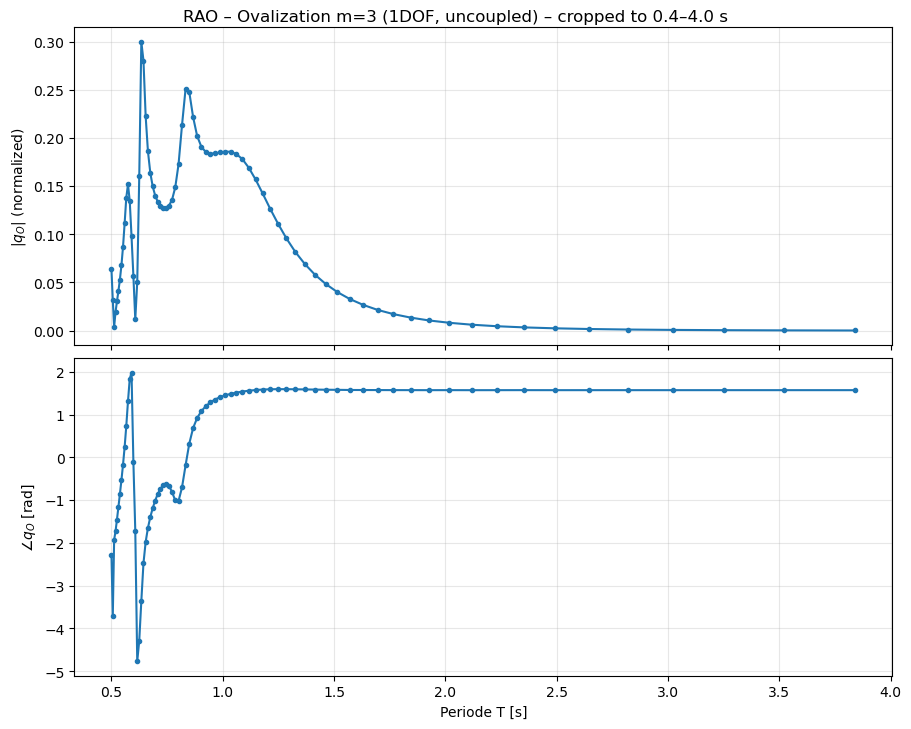

In [ ]:
# ---- RAO m=3 ----

beta_pick = 0.0
O = "Ovalization_m3"
m = 3

#sorter omega/T på økende periode
omega = np.asarray(omega_run, float)
omega = omega[np.isfinite(omega)]
omega.sort()
T = 2*np.pi / omega

idx = np.argsort(T)
omega = omega[idx]
T = T[idx]


# Hydrodynamics diagonal (fra rad_ds_4_m3)
#endre etter å ha kjørt m=3 radiation
rad = rad_ds_O
try:
    rad = rad.assign_coords(
        radiating_dof=rad["radiating_dof"].astype(str),
        influenced_dof=rad["influenced_dof"].astype(str),
    )
except Exception:
    pass

#sjekk at O finnes
if O not in set(rad["radiating_dof"].values.astype(str)):
    raise KeyError(f"DOF '{O}' finnes ikke i rad_ds_4_m3['radiating_dof'].")

A_OO = np.real(
    rad["added_mass"].sel(radiating_dof=O, influenced_dof=O).sel(omega=omega).values
).astype(float)

B_OO = np.real(
    rad["radiation_damping"].sel(radiating_dof=O, influenced_dof=O).sel(omega=omega).values
).astype(float)


# Excitation 
diff = diff_ds_4_m3
F = diff["excitation_force"]
try:
    F = F.assign_coords(influenced_dof=F["influenced_dof"].astype(str))
except Exception:
    pass

if "wave_direction" in F.dims:
    wd = np.asarray(F["wave_direction"].values, float)
    if np.any(wd == beta_pick):
        F = F.sel(wave_direction=beta_pick)
    else:
        i = int(np.argmin(np.abs(wd - beta_pick)))
        F = F.isel(wave_direction=i)

if O not in set(F["influenced_dof"].values.astype(str)):
    raise KeyError(f"DOF '{O}' finnes ikke i diff_ds_4_m3['excitation_force'].influenced_dof")

F_O = np.asarray(
    F.sel(influenced_dof=O).sel(omega=omega).values
).squeeze().astype(complex)



# Strukturledd )
R = float(R_ring)

# lineær masse per lengde (hvis du bruker den):
mu = float(M_ring) / (2*np.pi*R)   # [kg/m]
m2D = float(mu)

EI_loc = float(EI)

M_gen = m2D * np.pi * R
lam = (m**2 * (m**2 - 1)) / (R**4)
K_gen = EI_loc * lam * (np.pi * R)

zeta = 0.01
C_gen = 2*zeta*np.sqrt(K_gen*M_gen)

"""
R = float(R_ring)
mu = M_ring/(2*np.pi*R)
M_gen = mu*R*np.pi  # = 0.5*M_ring

K_gen = (EI/(R**3)) * np.pi * ((m**2) * (m**2 - 1)**2)

zeta = 0.01
C_gen = 2*zeta*np.sqrt(K_gen*M_gen)
"""



# 1DOF RAO
Z = -(omega**2)*(M_gen + A_OO) + 1j*omega*(C_gen + B_OO) + K_gen
qO = F_O / Z

# Crop: utelat numerisk støy

Tmin = 0.8   
Tmax = 4.0
maskT = (T >= Tmin) & (T <= Tmax)

T_c = T[maskT]
qO_c = qO[maskT]



# Plot (croppet)
fig, ax = plt.subplots(2, 1, figsize=(9, 7), constrained_layout=True, sharex=True)
fig.suptitle(f"RAO – Ovalization m={m} (1DOF, uncoupled) – cropped to {Tmin:.1f}–{Tmax:.1f} s", y=1.02)

ax[0].plot(T_c, np.abs(qO_c), "-o", ms=3)
ax[0].set_ylabel(r"$|q_O|$ (normalized)")
ax[0].grid(True, alpha=0.3)

ax[1].plot(T_c, np.unwrap(np.angle(qO_c)), "-o", ms=3)
ax[1].set_xlabel("Periode T [s]")
ax[1].set_ylabel(r"$\angle q_O$ [rad]")
ax[1].grid(True, alpha=0.3)

plt.show()



RAO_m3_uncoupled = qO
